In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline
from scipy import integrate
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import cg

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.pyplot import figure

In [3]:
nx, ny, nz = (16, 16, 16) #Choose number of basis functions on each axis
x = np.linspace(0, 1, nx + 2) #knots: nx+k+1 (k = 1, i.e. linear splines/ hat functions)
y = np.linspace(0, 1, ny + 2)
z = np.linspace(0, 1, nz + 2)
a1 = np.identity(nx + 2)
a2 = np.identity(ny + 2)
a3 = np.identity(nz + 2)
h1 = x[1] - x[0]
h2 = y[1] - y[0]
h3 = z[1] - z[0]
x_0 = np.concatenate(([- h1], x, [1 + h1]))
y_0 = np.concatenate(([- h2], y, [1 + h2]))
z_0 = np.concatenate(([- h3], z, [1 + h3]))

In [4]:
X, Y, Z = np.meshgrid(x, y, z)
print(X.shape)
print(X)
Xm = (X[:-1,:-1,:-1] + X[1:,1:,1:]) / 2
Ym = (Y[:-1,:-1,:-1] + Y[1:,1:,1:]) / 2
Zm = (Z[:-1,:-1,:-1] + Z[1:,1:,1:]) / 2

(18, 18, 18)
[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.05882353 0.05882353 0.05882353 ... 0.05882353 0.05882353 0.05882353]
  [0.11764706 0.11764706 0.11764706 ... 0.11764706 0.11764706 0.11764706]
  ...
  [0.88235294 0.88235294 0.88235294 ... 0.88235294 0.88235294 0.88235294]
  [0.94117647 0.94117647 0.94117647 ... 0.94117647 0.94117647 0.94117647]
  [1.         1.         1.         ... 1.         1.         1.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.05882353 0.05882353 0.05882353 ... 0.05882353 0.05882353 0.05882353]
  [0.11764706 0.11764706 0.11764706 ... 0.11764706 0.11764706 0.11764706]
  ...
  [0.88235294 0.88235294 0.88235294 ... 0.88235294 0.88235294 0.88235294]
  [0.94117647 0.94117647 0.94117647 ... 0.94117647 0.94117647 0.94117647]
  [1.         1.         1.         ... 1.         1.         1.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.0588

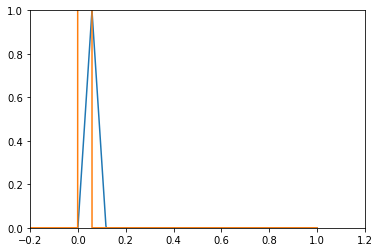

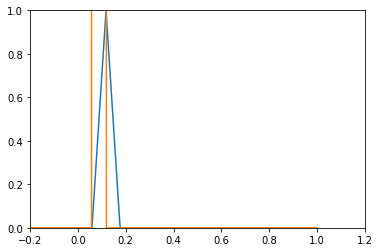

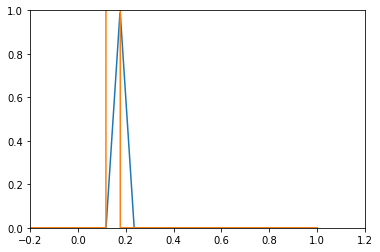

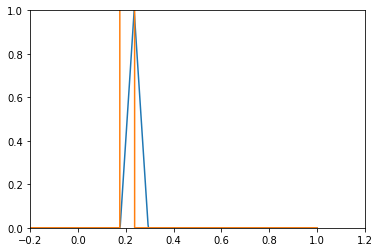

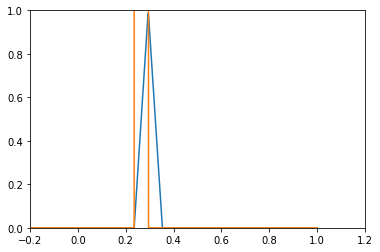

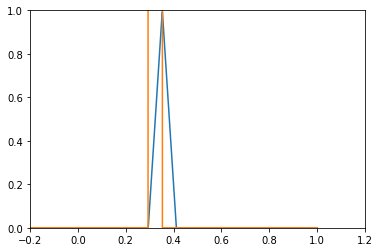

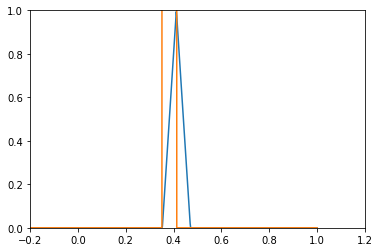

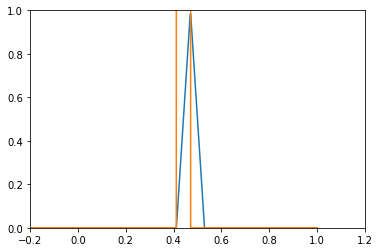

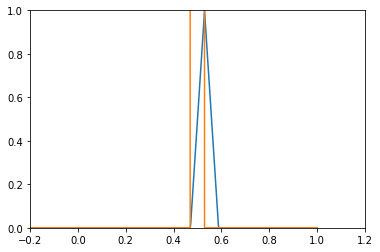

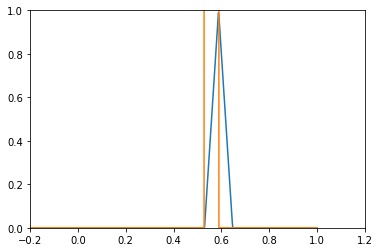

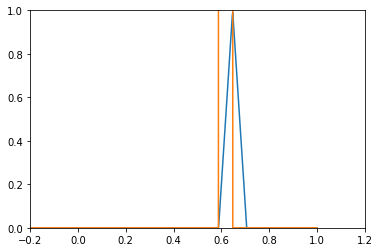

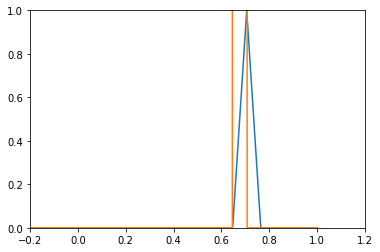

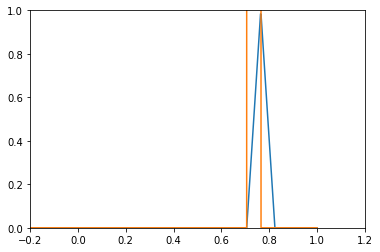

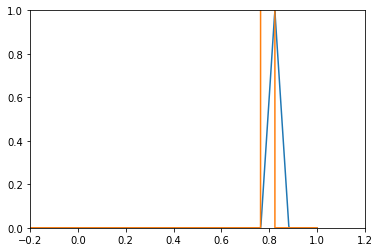

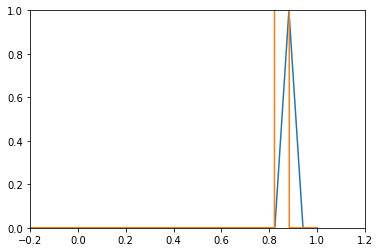

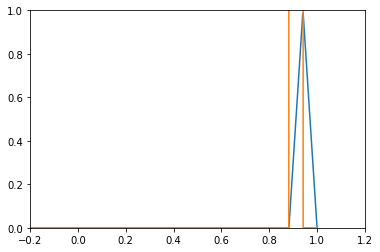

In [5]:
test = np.linspace(-1, 1, 1000)
def Dspl1(t,i1):
        if x[i1 - 1] > t or t >= x[i1]: #Numbering of Dspl functions starts from 0, whereas the numbering of the b-spline functions starts from 1
            return 0
        else:
            return 1 / h1
v_Dspl1 = np.vectorize(Dspl1)
for j in range (1, nx + 1):
    spl1 = BSpline(x_0, a1[j, :], 1)
    plt.plot(test, spl1(test))
    plt.plot(test, v_Dspl1(test, j))
    axes = plt.gca()
    axes.set_xlim([- 0.2, 1.2])
    axes.set_ylim([0, 1])
    plt.show()

In [6]:
E = lambda x, y, z: [(1 - x) * (1 - y) * (1 - z) * x * y * z, (1 - x) * (1 - y) * (1 - z) * x * y * z, (1 - x) * (1 - y) * (1 - z) * x * y * z]

J = lambda x, y, z: [(1 - x) * (1 - y) * (1 - z) * x * y * z + y * (y - 1) * (2 * x ** 2 - 4 * x * z + 2 * z - 1) 
                     + z * (z - 1) * (2 * x ** 2 - 4 * x * y + 2 * y - 1), 
                     (1 - x) * (1 - y) * (1 - z) * x * y * z + x * (x - 1) * (2 * y ** 2 - 4 * y * z + 2 * z - 1)
                     - z * (z - 1) * (4 * x * y - 2 * x - 2 * y ** 2 + 1), 
                     (1 - x) * (1 - y) * (1 - z) * x * y * z - x * (x - 1) * (4 * y * z - 2 * y - 2 * z ** 2 + 1) 
                     - y * (y - 1) * (4 * x * z - 2 * x - 2 * z ** 2 + 1)]

def basisfct(x1, x2, x3, i1, i2, i3): #Choose 1<=i1<=nx, 1<=i2<=ny, 1<=i3<=nz
    if i1 < 1 or i1 > nx:
        def spl1(t):
            return 0
    else:
        spl1 = BSpline(x_0, a1[i1, :], 1)
    if i2 < 1 or i2 > ny:
        def spl2(t):
            return 0
    else:
        spl2 = BSpline(y_0, a2[i2, :], 1)
    if i1 < 1 or i1 > nx:
        def spl3(t):
            return 0
    else:    
        spl3 = BSpline(z_0, a3[i3, :], 1)
    
    def Dspl1(t, i1):
        if i1 < 1 or i1 > nx:
            return 0
        else:
            if x[i1 - 1] > t or t >= x[i1]: #Numbering of Dspl functions starts from 0, whereas the numbering of the b-spline functions starts from 1
                return 0
            else:
                return 1 / h1

    def Dspl2(t, i2):
        if i2 < 1 or i2 > ny:
            return 0
        else:
            if y[i2 - 1] > t or t >= y[i2]:
                return 0
            else:
                return 1 / h2

    def Dspl3(t, i3):
        if i3 < 1 or i3 > nz:
            return 0
        else:
            if z[i3 - 1] > t or t >= z[i3]:
                return 0
            else:
                return 1 / h3

    return ([Dspl1(x1, i1) * spl2(x2) * spl3(x3), spl1(x1) * Dspl2(x2, i2) * spl3(x3), spl1(x1) * spl2(x2) * Dspl3(x3, i3)])


In [7]:
b = h1 ** 2 / 4 * (J(Xm[:-1, :-1, :-1], Ym[:-1, :-1, :-1], Zm[:-1, :-1, :-1])[0] + J(Xm[:-1, :-1, :-1], Ym[:-1, :-1, :-1], Zm[1:, 1:, 1:])[0]
                   + J(Xm[:-1, :-1, :-1], Ym[1:, 1:, 1:], Zm[:-1, :-1, :-1])[0] + J(Xm[:-1, :-1, :-1], Ym[1:, 1:, 1:], Zm[1:, 1:, 1:])[0]
                    
                   + J(Xm[:-1, :-1, :-1], Ym[:-1, :-1, :-1], Zm[:-1, :-1, :-1])[1] + J(Xm[:-1, :-1, :-1], Ym[:-1, :-1, :-1], Zm[1:, 1:, 1:])[1]
                   + J(Xm[1:, 1:, 1:], Ym[:-1, :-1, :-1], Zm[:-1, :-1, :-1])[1] + J(Xm[1:, 1:, 1:], Ym[:-1, :-1, :-1], Zm[1:, 1:, 1:])[1]
                   
                   + J(Xm[:-1, :-1, :-1], Ym[:-1, :-1, :-1], Zm[:-1, :-1, :-1])[2] + J(Xm[1:, 1:, 1:], Ym[:-1, :-1, :-1], Zm[:-1, :-1, :-1])[2]
                   + J(Xm[:-1, :-1, :-1], Ym[1:, 1:, 1:], Zm[:-1, :-1, :-1])[2] + J(Xm[1:, 1:, 1:], Ym[1:, 1:, 1:], Zm[:-1, :-1, :-1])[2])

print(Xm.shape)
print(b.shape)
b_vector = np.reshape(b, nx * ny * nz)
print(b_vector.shape)

(17, 17, 17)
(16, 16, 16)
(4096,)


In [8]:
row = []
col = []
data = []

for i in range(0, nx):
    for j in range(0, ny):
        for k in range(0, nz):
            
            row.append(nz * (i * ny + j) + k)
            col.append(nz * (i * ny + j) + k)
            data.append(4 / 9 * (h2 * h3 / h1  + h1 * h3 / h2  + h1 * h2 / h3) + 4 / 3 * (h1 / (h2 * h3) + h2 / (h1 * h3) + h3 / (h1 * h2)))
            
            if j != ny - 1:
                row.append(nz * (i * ny + j) + k) 
                col.append(nz * (i * ny + j + 1) + k)
                data.append(1 / 9 * (h2 * h3 / h1  + h1 * h2 / h3) + h2 / (3 * h1 * h3))
            
                if k != nz - 1:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * (i * ny + j + 1) + k + 1)
                    data.append(1 / 36 * h2 * h3 / h1)
                    
            if j != 0:
                row.append(nz * (i * ny + j) + k)
                col.append(nz * (i * ny + j - 1) + k)
                data.append(1 / 9 * (h2 * h3 / h1  + h1 * h2 / h3) + h2 / (3 * h1 * h3))
                
                if k != 0:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * (i * ny + j - 1) + k - 1)
                    data.append(1 / 36 * h2 * h3 / h1)
                    
            if k != nz - 1:
                row.append(nz * (i * ny + j) + k)
                col.append(nz * (i * ny + j) + k + 1)
                data.append(1 / 9 * (h2 * h3 / h1  + h1 * h3 / h2) + h3 / (3 * h1 * h2))
                
            if k != 0:
                row.append(nz * (i * ny + j) + k)
                col.append(nz * (i * ny + j) + k - 1)
                data.append(1 / 9 * (h2 * h3 / h1  + h1 * h3 / h2) + h3 / (3 * h1 * h2))

            if i != nx - 1:
                row.append(nz * (i * ny + j) + k)
                col.append(nz * ((i + 1) * ny + j) + k)
                data.append(1 / 9 * (h1 * h3 / h2  + h1 * h2 / h3) + h1 / (3 * h2 * h3))

                if j != ny - 1 and k != 0:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i + 1) * ny + j + 1) + k - 1)
                    data.append(- 1 / 6 * (h1 / (h2 * h3) + h2 / (h1 * h3)))
                if j != 0:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i + 1) * ny + j - 1) + k)
                    data.append(1 / 36 * h1 * h2 / h3 - 2 / 3 * h3 / (h1 * h2))

                    if k != nz - 1:
                        row.append(nz * (i * ny + j) + k)
                        col.append(nz * ((i + 1) * ny + j - 1) + k + 1)
                        data.append(- 1 / 6 * (h1 / (h2 * h3) + h3 / (h1 * h2)))
                    if k != 0:
                        row.append(nz * (i * ny + j) + k)
                        col.append(nz * ((i + 1) * ny + j - 1) + k - 1)
                        data.append(- 1 / 6 * (h2 / (h1 * h3) + h3 / (h1 * h2)))
                if k != 0:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i + 1) * ny + j) + k - 1)
                    data.append(1 / 36 * h1 * h3 / h2 - 2 / 3 * h2 / (h1 * h3))

                if k != nz - 1:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i + 1) * ny + j) + k + 1)
                    data.append(1 / 36 * h1 * h3 / h2)

                if j != ny - 1:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i + 1) * ny + j + 1) + k)
                    data.append(1 / 36 * h1 * h2 / h3)

            
            if i != 0:
                row.append(nz * (i * ny + j) + k)
                col.append(nz * ((i - 1) * ny + j) + k)
                data.append(1 / 9 * (h1 * h3 / h2  + h1 * h2 / h3) + h1 / (3 * h2 * h3))

                if j != ny - 1:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i - 1) * ny + j + 1) + k)
                    data.append(1 / 36 * h1 * h2 / h3 - 2 / 3 * h3 / (h1 * h2))

                    if k != 0:
                        row.append(nz * (i * ny + j) + k)
                        col.append(nz * ((i - 1) * ny + j + 1) + k - 1)
                        data.append(- 1 / 6 * (h1 / (h2 * h3) + h3 / (h1 * h2)))
                    if k != nz - 1:
                        row.append(nz * (i * ny + j) + k)
                        col.append(nz * ((i - 1) * ny + j + 1) + k + 1)
                        data.append(- 1 / 6 * (h2 / (h1 * h3) + h3 / (h1 * h2)))
                if k != nz - 1:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i - 1) * ny + j) + k + 1)
                    data.append(1 / 36 * h1 * h3 / h2 - 2 / 3 * h2 / (h1 * h3))

                if j != 0 and k != nz - 1:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i - 1) * ny + j - 1) + k + 1)
                    data.append(- 1 / 6 * (h1 / (h2 * h3) + h2 / (h1 * h3)))
                if k != 0:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i - 1) * ny + j) + k - 1)
                    data.append(1 / 36 * h1 * h3 / h2)

                if j != 0:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i - 1) * ny + j - 1) + k)
                    data.append(1 / 36 * h1 * h2 / h3)
                                  
            if j != 0 and k != nz - 1:
                row.append(nz * (i * ny + j) + k)
                col.append(nz * (i * ny + j - 1) + k + 1)
                data.append(1 / 36 * h2 * h3 / h1  - 2 / 3 * h1 / (h2 * h3))
                                    
            if j != ny - 1 and k != 0:
                row.append(nz * (i * ny + j) + k)
                col.append(nz * (i * ny + j + 1) + k - 1)
                data.append(1 / 36 * h2 * h3 / h1 - 2 / 3 * h1 / (h2 * h3))


row = np.array(row)
col = np.array(col)
data = np.array(data)

In [10]:
Syst_matrix = coo_matrix((data, (row, col)))
print(Syst_matrix.toarray().shape)
u = cg(Syst_matrix.tocsc(), b_vector)
u = u[0]
print(u)

(4096, 4096)
[1.00524424e-05 1.88144833e-05 2.63155381e-05 ... 2.63733370e-05
 1.88496675e-05 1.00671365e-05]


In [60]:
u_tensor = np.reshape(u, (nx, ny, nz))
def solution(x1, x2, x3):
    s = 0
    if x1 == 0:
        i = 1
    else:
        if x1 >= x[nx]:
            i = nx
        else:
            i = np.nonzero([x >= x1])[1][0]
            
    if x2 == 0:
        j = 1
    else:
        if x2 >= y[ny]:
            j = ny
        else:
            j = np.nonzero([y >= x2])[1][0]
            
    if x3 == 0:
        k = 1
    else:
        if x3 >= z[nz]:
            k = nz
        else:
            k = np.nonzero([z >= x3])[1][0]
            
    s = np.multiply(u_tensor[i - 1, j - 2, k - 2] if (0 <= i - 1 <= nx - 1 and 0 <= j - 2 <= ny - 1 and 0 <= k - 2 <= nz - 1) else 0, basisfct(x1, x2, x3, i, j - 1, k - 1))\
        + np.multiply(u_tensor[i - 1, j - 2, k - 1] if (0 <= i - 1 <= nx - 1 and 0 <= j - 2 <= ny - 1 and 0 <= k - 1 <= nz - 1) else 0, basisfct(x1, x2, x3, i, j - 1, k))\
        + np.multiply(u_tensor[i - 1, j - 2, k] if (0 <= i - 1 <= nx - 1 and 0 <= j - 2 <= ny - 1 and 0 <= k <= nz - 1) else 0, basisfct(x1, x2, x3, i, j - 1, k + 1))\
        + np.multiply(u_tensor[i - 1, j - 1, k - 2] if (0 <= i - 1 <= nx - 1 and 0 <= j - 1 <= ny - 1 and 0 <= k - 2 <= nz - 1) else 0, basisfct(x1, x2, x3, i, j, k - 1))\
        + np.multiply(u_tensor[i - 1, j - 1, k - 1] if (0 <= i - 1<= nx - 1 and 0 <= j - 1 <= ny - 1 and 0 <= k - 1 <= nz - 1) else 0, basisfct(x1, x2, x3, i, j, k))\
        + np.multiply(u_tensor[i - 1, j - 1, k] if (0 <= i - 1 <= nx - 1 and 0 <= j - 1 <= ny - 1 and 0 <= k <= nz - 1) else 0, basisfct(x1, x2, x3, i, j, k + 1))\
        + np.multiply(u_tensor[i - 1, j, k - 2] if (0 <= i - 1 <= nx - 1 and 0 <= j <= ny - 1 and 0 <= k - 2 <= nz - 1) else 0, basisfct(x1, x2, x3, i, j + 1, k - 1))\
        + np.multiply(u_tensor[i - 1, j, k - 1] if (0 <= i - 1 <= nx - 1 and 0 <= j <= ny - 1 and 0 <= k - 1 <= nz - 1) else 0, basisfct(x1, x2, x3, i, j + 1, k))\
        + np.multiply(u_tensor[i - 1, j, k] if (0 <= i - 1 <= nx - 1 and 0 <= j <= ny - 1 and 0 <= k <= nz - 1) else 0, basisfct(x1, x2, x3, i, j + 1, k + 1))\
        + np.multiply(u_tensor[i - 2, j - 1, k - 2] if (0 <= i - 2 <= nx - 1 and 0 <= j - 1 <= ny - 1 and 0 <= k - 2 <= nz - 1) else 0, basisfct(x1, x2, x3, i - 1, j, k - 1))\
        + np.multiply(u_tensor[i, j - 1, k - 2] if (0 <= i <= nx - 1 and 0 <= j - 1 <= ny - 1 and 0 <= k - 2 <= nz - 1) else 0, basisfct(x1, x2, x3, i + 1, j, k - 1))\
        + np.multiply(u_tensor[i - 2, j - 1, k - 1] if (0 <= i - 2 <= nx - 1 and 0 <= j - 1 <= ny - 1 and 0 <= k - 1 <= nz - 1) else 0, basisfct(x1, x2, x3, i - 1, j, k))\
        + np.multiply(u_tensor[i, j - 1, k - 1] if (0 <= i <= nx - 1 and 0 <= j - 1 <= ny - 1 and 0 <= k - 1 <= nz - 1) else 0, basisfct(x1, x2, x3, i + 1, j, k))\
        + np.multiply(u_tensor[i - 2, j - 1, k] if (0 <= i - 2 <= nx - 1 and 0 <= j - 1 <= ny - 1 and 0 <= k <= nz - 1) else 0, basisfct(x1, x2, x3, i - 1, j, k + 1))\
        + np.multiply(u_tensor[i, j - 1, k] if (0 <= i <= nx - 1 and 0 <= j - 1 <= ny - 1 and 0 <= k <= nz - 1) else 0, basisfct(x1, x2, x3, i + 1, j, k + 1))\
        + np.multiply(u_tensor[i - 2, j - 2, k - 1] if (0 <= i - 2 <= nx - 1 and 0 <= j - 2 <= ny - 1 and 0 <= k - 1 <= nz - 1) else 0, basisfct(x1, x2, x3, i - 1, j - 1, k))\
        + np.multiply(u_tensor[i - 2, j, k - 1] if (0 <= i - 2 <= nx - 1 and 0 <= j <= ny - 1 and 0 <= k - 1 <= nz - 1) else 0, basisfct(x1, x2, x3, i - 1, j + 1, k))\
        + np.multiply(u_tensor[i, j - 2, k - 1] if (0 <= i <= nx - 1 and 0 <= j - 2 <= ny - 1 and 0 <= k - 1 <= nz - 1) else 0, basisfct(x1, x2, x3, i + 1, j - 1, k))\
        + np.multiply(u_tensor[i, j, k - 1] if (0 <= i <= nx - 1 and 0 <= j <= ny - 1 and 0 <= k - 1 <= nz - 1) else 0, basisfct(x1, x2, x3, i + 1, j + 1, k))\
        
    return s

#print(u_tensor)

[[[1.41303853e-08 2.79106342e-08 4.14169287e-08 ... 4.13659142e-08
   2.78885301e-08 1.40921765e-08]
  [2.79106342e-08 5.52333545e-08 8.18662307e-08 ... 8.18122583e-08
   5.51487344e-08 2.78714898e-08]
  [4.14169287e-08 8.18662307e-08 1.21439902e-07 ... 1.21328045e-07
   8.17886954e-08 4.13383350e-08]
  ...
  [4.13659142e-08 8.18122583e-08 1.21328045e-07 ... 1.21622629e-07
   8.20030948e-08 4.14620142e-08]
  [2.78885301e-08 5.51487344e-08 8.17886954e-08 ... 8.20030948e-08
   5.52845172e-08 2.79464483e-08]
  [1.40921765e-08 2.78714898e-08 4.13383350e-08 ... 4.14620142e-08
   2.79464483e-08 1.41229977e-08]]

 [[2.79106342e-08 5.52333545e-08 8.18662307e-08 ... 8.18122583e-08
   5.51487344e-08 2.78714898e-08]
  [5.52333545e-08 1.09162398e-07 1.61945776e-07 ... 1.61791334e-07
   1.09065469e-07 5.51302485e-08]
  [8.18662307e-08 1.61945776e-07 2.40152434e-07 ... 2.39949292e-07
   1.61758492e-07 8.17690781e-08]
  ...
  [8.18122583e-08 1.61791334e-07 2.39949292e-07 ... 2.40438082e-07
   1.62095

In [61]:
row1 = []
col1 = []
data1 = []
row2 = []
col2 = []
data2 = []
row3 = []
col3 = []
data3 = []

for i in range(0, nx):
    for j in range(0, ny):
        for k in range(0, nz):
            
            row1.append(nz * (i * ny + j) + k)
            col1.append(nz * (i * ny + j) + k)
            data1.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j) + k] * 4 / 9 * h2 * h3 / h1)
            row2.append(nz * (i * ny + j) + k)
            col2.append(nz * (i * ny + j) + k)
            data2.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j) + k] * 4 / 9 * h1 * h3 / h2)
            row3.append(nz * (i * ny + j) + k)
            col3.append(nz * (i * ny + j) + k)
            data3.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j) + k] * 4 / 9 * h1 * h2 / h3)
            
            if j != ny - 1:
                row1.append(nz * (i * ny + j) + k)
                col1.append(nz * (i * ny + j + 1) + k)
                data1.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j + 1) + k] * 1 / 9 * h2 * h3 / h1)
                row3.append(nz * (i * ny + j) + k)
                col3.append(nz * (i * ny + j + 1) + k)
                data3.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j + 1) + k] * 1 / 9 * h1 * h2 / h3)
            
                if k != nz - 1:
                    row1.append(nz * (i * ny + j) + k)
                    col1.append(nz * (i * ny + j + 1) + k + 1)
                    data1.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j + 1) + k + 1] * 1 / 36 * h2 * h3 / h1)
            if j != 0:
                row1.append(nz * (i * ny + j) + k)
                col1.append(nz * (i * ny + j - 1) + k)
                data1.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j - 1) + k] * 1 / 9 * h2 * h3 / h1)
                row3.append(nz * (i * ny + j) + k)
                col3.append(nz * (i * ny + j - 1) + k)
                data3.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j - 1) + k] * 1 / 9 * h1 * h2 / h3)
                
                if k != 0:
                    row1.append(nz * (i * ny + j) + k)
                    col1.append(nz * (i * ny + j - 1) + k - 1)
                    data1.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j - 1) + k - 1] * 1 / 36 * h2 * h3 / h1)
            if k != nz - 1:
                row1.append(nz * (i * ny + j) + k)
                col1.append(nz * (i * ny + j) + k + 1)
                data1.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j) + k + 1] * 1 / 9 * h2 * h3 / h1)
                row2.append(nz * (i * ny + j) + k)
                col2.append(nz * (i * ny + j) + k + 1)
                data2.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j) + k + 1] * 1 / 9 * h1 * h3 / h2)
                
            if k != 0:
                row1.append(nz * (i * ny + j) + k)
                col1.append(nz * (i * ny + j) + k - 1)
                data1.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j) + k - 1] * 1 / 9 * h2 * h3 / h1)
                row2.append(nz * (i * ny + j) + k)
                col2.append(nz * (i * ny + j) + k - 1)
                data2.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j) + k - 1] * 1 / 9 * h1 * h3 / h2)
            
            if i != nx - 1:
                row2.append(nz * (i * ny + j) + k)
                col2.append(nz * ((i + 1) * ny + j) + k)
                data2.append(u[nz * (i * ny + j) + k] * u[nz * ((i + 1) * ny + j) + k] * 1 / 9 * h1 * h3 / h2)
                row3.append(nz * (i * ny + j) + k)
                col3.append(nz * ((i + 1) * ny + j) + k)
                data3.append(u[nz * (i * ny + j) + k] * u[nz * ((i + 1) * ny + j) + k] * 1 / 9 * h1 * h2 / h3)
                if j != 0:
                    row3.append(nz * (i * ny + j) + k)
                    col3.append(nz * ((i + 1) * ny + j - 1) + k)
                    data3.append(u[nz * (i * ny + j) + k] * u[nz * ((i + 1) * ny + j - 1) + k] * 1 / 36 * h1 * h2 / h3)
                if k != 0:
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * ((i + 1) * ny + j) + k - 1)
                    data2.append(u[nz * (i * ny + j) + k] * u[nz * ((i + 1) * ny + j) + k - 1] * 1 / 36 * h1 * h3 / h2)
                if k != nz - 1:
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * ((i + 1) * ny + j) + k + 1)
                    data2.append(u[nz * (i * ny + j) + k] * u[nz * ((i + 1) * ny + j) + k + 1] * 1 / 36 * h1 * h3 / h2)
                if j != ny - 1:
                    row3.append(nz * (i * ny + j) + k)
                    col3.append(nz * ((i + 1) * ny + j + 1) + k)
                    data3.append(u[nz * (i * ny + j) + k] * u[nz * ((i + 1) * ny + j + 1) + k] * 1 / 36 * h1 * h2 / h3)
            
            if i != 0:
                row2.append(nz * (i * ny + j) + k)
                col2.append(nz * ((i - 1) * ny + j) + k)
                data2.append(u[nz * (i * ny + j) + k] * u[nz * ((i - 1) * ny + j) + k] * 1 / 9 * h1 * h3 / h2)
                row3.append(nz * (i * ny + j) + k)
                col3.append(nz * ((i - 1) * ny + j) + k)
                data3.append(u[nz * (i * ny + j) + k] * u[nz * ((i - 1) * ny + j) + k] * 1 / 9 * h1 * h2 / h3)
                if j != ny - 1:
                    row3.append(nz * (i * ny + j) + k)
                    col3.append(nz * ((i - 1) * ny + j + 1) + k)
                    data3.append(u[nz * (i * ny + j) + k] * u[nz * ((i - 1) * ny + j + 1) + k] * 1 / 36 * h1 * h2 / h3)
                if k != nz - 1:
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * ((i - 1) * ny + j) + k + 1)
                    data2.append(u[nz * (i * ny + j) + k] * u[nz * ((i - 1) * ny + j) + k + 1] * 1 / 36 * h1 * h3 / h2)
                if k != 0:
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * ((i - 1) * ny + j) + k - 1)
                    data2.append(u[nz * (i * ny + j) + k] * u[nz * ((i - 1) * ny + j) + k - 1] * 1 / 36 * h1 * h3 / h2)
                if j != 0:
                    row3.append(nz * (i * ny + j) + k)
                    col3.append(nz * ((i - 1) * ny + j - 1) + k)
                    data3.append(u[nz * (i * ny + j) + k] * u[nz * ((i - 1) * ny + j - 1) + k] * 1 / 36 * h1 * h2 / h3)
                                  
            if j != 0 and k != nz - 1:
                row1.append(nz * (i * ny + j) + k)
                col1.append(nz * (i * ny + j - 1) + k + 1)
                data1.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j - 1) + k + 1] * 1 / 36 * h2 * h3 / h1)
                                    
            if j != ny - 1 and k != 0:
                row1.append(nz * (i * ny + j) + k)
                col1.append(nz * (i * ny + j + 1) + k - 1)
                data1.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j + 1) + k - 1] * 1 / 36 * h2 * h3 / h1)

row1 = np.array(row1)
col1 = np.array(col1)
data1 = np.array(data1)
row2 = np.array(row2)
col2 = np.array(col2)
data2 = np.array(data2)
row3 = np.array(row3)
col3 = np.array(col3)
data3 = np.array(data3)
int_Eh_squared_1 = coo_matrix((data1, (row1, col1)))
int_Eh_squared_2 = coo_matrix((data2, (row2, col2)))
int_Eh_squared_3 = coo_matrix((data3, (row3, col3)))
#print(int_Eh_squared_1.tocsc().sum())

3.703681391821012e-05


In [62]:
int_twoab1 = h1 ** 2 / 2 * u_tensor * (E(Xm[:-1, :-1, :-1], Ym[:-1, :-1, :-1], Zm[:-1, :-1, :-1])[0] + E(Xm[:-1, :-1, :-1], Ym[:-1, :-1, :-1], Zm[1:, 1:, 1:])[0]
                   + E(Xm[:-1, :-1, :-1], Ym[1:, 1:, 1:], Zm[:-1, :-1, :-1])[0] + E(Xm[:-1, :-1, :-1], Ym[1:, 1:, 1:], Zm[1:, 1:, 1:])[0])
                    
int_twoab2 = h2 ** 2 / 2 * u_tensor * (E(Xm[:-1, :-1, :-1], Ym[:-1, :-1, :-1], Zm[:-1, :-1, :-1])[1] + E(Xm[:-1, :-1, :-1], Ym[:-1, :-1, :-1], Zm[1:, 1:, 1:])[1]
                   + E(Xm[1:, 1:, 1:], Ym[:-1, :-1, :-1], Zm[:-1, :-1, :-1])[1] + E(Xm[1:, 1:, 1:], Ym[:-1, :-1, :-1], Zm[1:, 1:, 1:])[1])
                   
int_twoab3 = h3 ** 2 / 2 * u_tensor * (E(Xm[:-1, :-1, :-1], Ym[:-1, :-1, :-1], Zm[:-1, :-1, :-1])[2] + E(Xm[1:, 1:, 1:], Ym[:-1, :-1, :-1], Zm[:-1, :-1, :-1])[2]
                   + E(Xm[:-1, :-1, :-1], Ym[1:, 1:, 1:], Zm[:-1, :-1, :-1])[2] + E(Xm[1:, 1:, 1:], Ym[1:, 1:, 1:], Zm[:-1, :-1, :-1])[2])

#print(np.sum(int_twoab1))

In [63]:
int_E_squared_1 = h1 * h2 * h3 * E(Xm, Ym, Zm)[0] ** 2
int_E_squared_2 = h1 * h2 * h3 * E(Xm, Ym, Zm)[1] ** 2
int_E_squared_3 = h1 * h2 * h3 * E(Xm, Ym, Zm)[2] ** 2
#print(np.sum(int_E_squared_1))

3.7037038454788105e-05
3.7165905711789056e-05


In [64]:
error = np.sqrt(np.sum(int_E_squared_1) + int_Eh_squared_1.tocsc().sum() - np.sum(int_twoab1))\
        + np.sqrt(np.sum(int_E_squared_2) + int_Eh_squared_2.tocsc().sum() - np.sum(int_twoab2))\
        + np.sqrt(np.sum(int_E_squared_3) + int_Eh_squared_3.tocsc().sum() - np.sum(int_twoab3))
#print(error)

0.00040753350309767926


In [1]:
test = np.linspace(0, 1, 100)
#print(solution)
def sol(x):
    return solution(0.2,0.2,x)[0]
sol0 = np.vectorize(sol)
#def sol2(x):
 #   return solution2(0.2,0.2,x)[0]
#sol2 = np.vectorize(sol2)
print(sol0(test))
#print(sol2(test))
#print(E(0.5,0.1,test)[0])


plt.plot(test,sol0(test))
plt.plot(test,E(0.2,0.2,test)[0])
axes = plt.gca()
plt.title('solution(0.2,0.2,x)[0], n = 16')
axes.set_xlim([-0.2,1.2])
axes.set_ylim([-0.002,0.008])
plt.show()

NameError: name 'np' is not defined

In [49]:
def trplint(f):
    n = 20
    int = 0
    x1 = np.linspace(0, 1, n)
    x2 = np.linspace(0, 1, n)
    x3 = np.linspace(0, 1, n)
    d = x1[1] - x1[0]
    for i in range(0, n):
        for j in range(0, n):
            for k in range(0, n):
                int += d ** 3 * f((2 * i + 1) * d / 2, (2 * j + 1) * d / 2, (2 * k + 1) * d / 2)
    return int

In [226]:
def error0(x, y, z):
    return((E(x, y, z)[0] - solution(x, y, z)[0]) ** 2)

def error1(x, y, z):
    return((E(x, y, z)[1] - solution(x, y, z)[1]) ** 2)

def error2(x, y, z):
    return((E(x, y, z)[2] - solution(x, y, z)[2]) ** 2)


print(np.sqrt(trplint(error0)) + np.sqrt(trplint(error1)) + np.sqrt(trplint(error2)))

0.0035096666043995337


In [110]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.pyplot import figure

def ff(x,y):
    v = np.zeros(len(x))
    for i in range(0,len(x)):
        v[i] = solution(x[i],y[i],0.2)[0]
    return(v)

X = np.arange(0, 1.05, 0.05)
Y = np.arange(0, 1.05, 0.05)
X, Y = np.meshgrid(X, Y)
print(len(X))
Z = E(X,Y,0.2)[0]
#print(Z)
Z2 = np.zeros(shape = (len(X),len(X)))
for k in range(0, len(X)):
    Z2[k] = ff(X[k],Y[k])

21


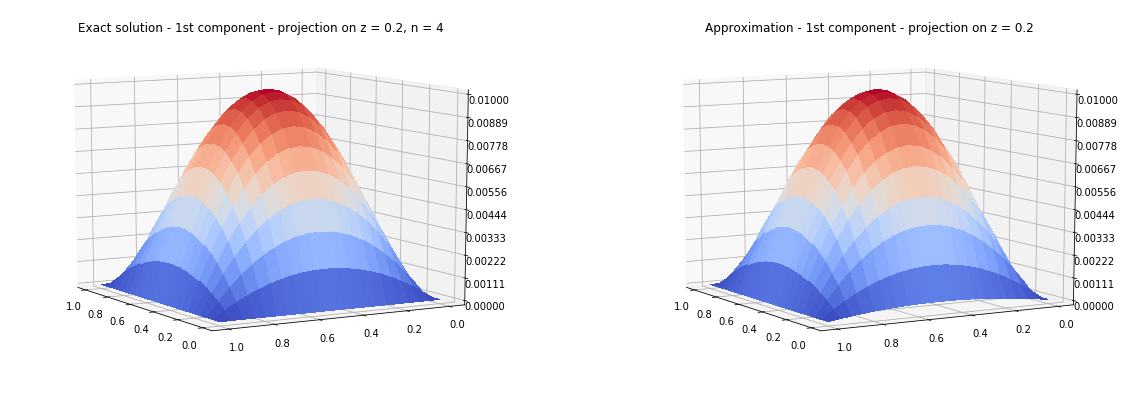

In [158]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, subplot_kw = {"projection": "3d"}, figsize=(20, 7))

surf1 = ax1.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
surf2 = ax2.plot_surface(X, Y, Z2, cmap=cm.coolwarm,linewidth=0, antialiased=False)

# Customize the z axis.
ax1.set_zlim(0, 0.01)
ax1.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter('{x:.02f}')
ax1.view_init(10, 150)
ax1.set_title('Exact solution - 1st component - projection on z = 0.2')
#fig.colorbar(surf1, shrink=0.5, aspect=5)

# Customize the z axis.
ax2.set_zlim(0, 0.01)
ax2.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter('{x:.02f}')
ax2.view_init(10, 150)
ax2.set_title('Approximation - 1st component - projection on z = 0.2')
#fig.colorbar(surf2, shrink=0.5, aspect=5)
plt.savefig('plot3.pdf')

plt.show()

0.004116155425602337
21


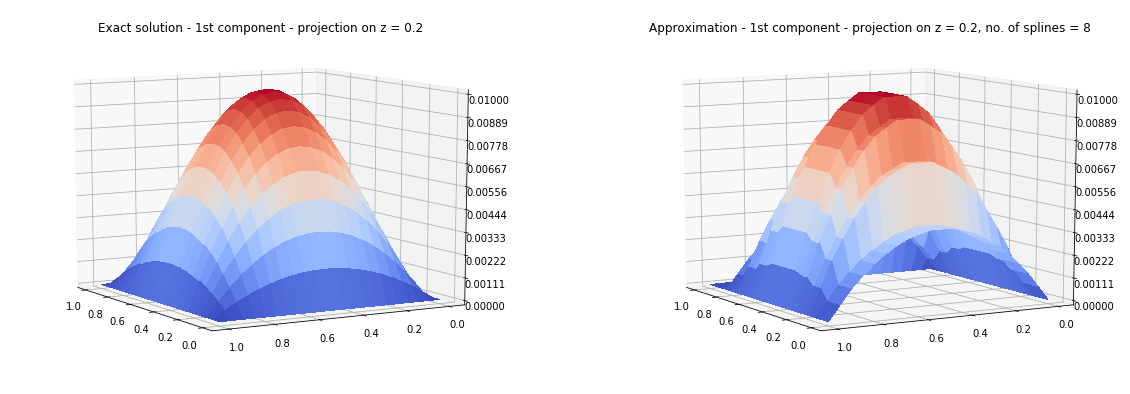

0.00218085095760924
21


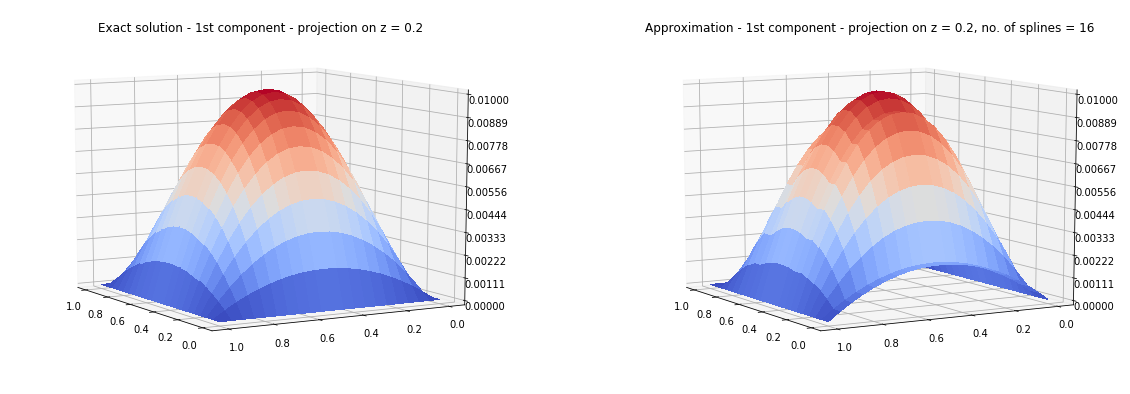

0.0014832252012887174
21


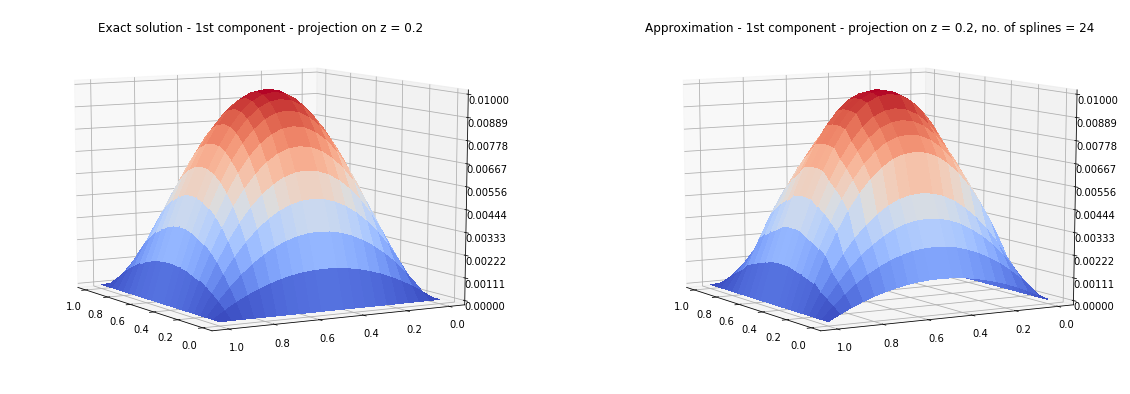

0.0011237240943338276
21


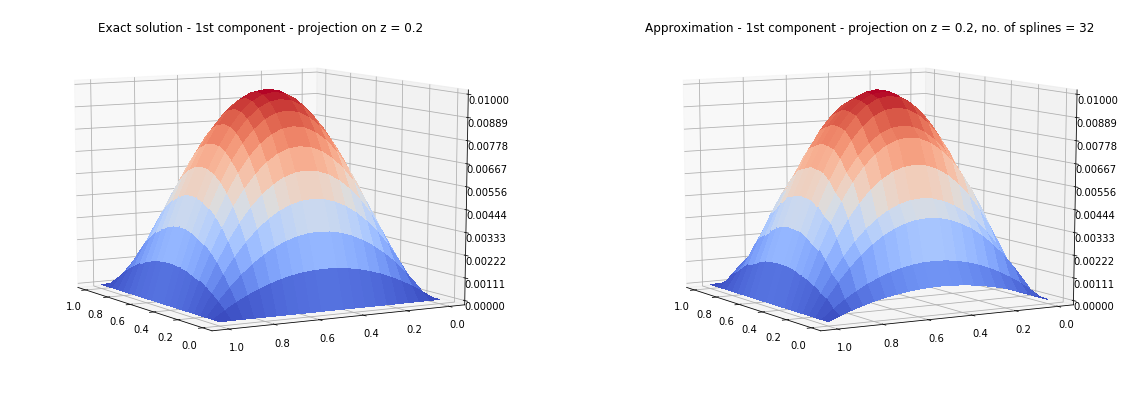

0.0008624221059933387
21


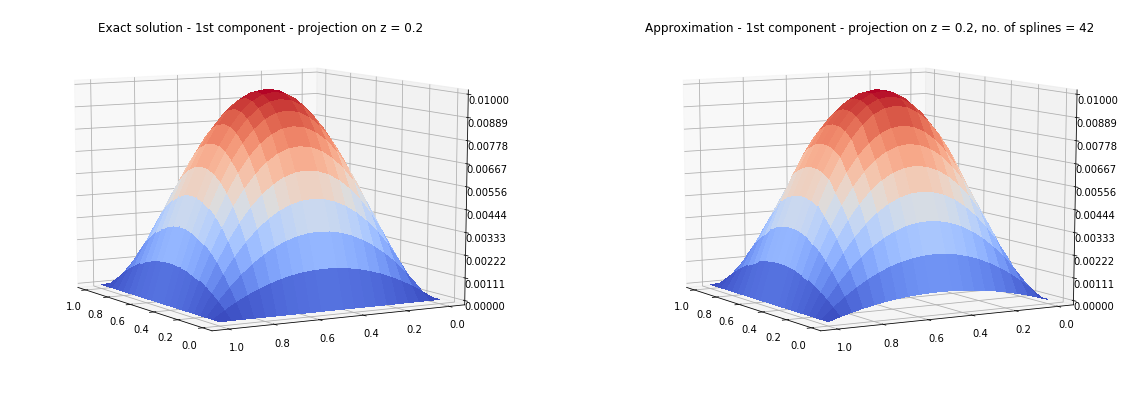

0.0007271504097053758
21


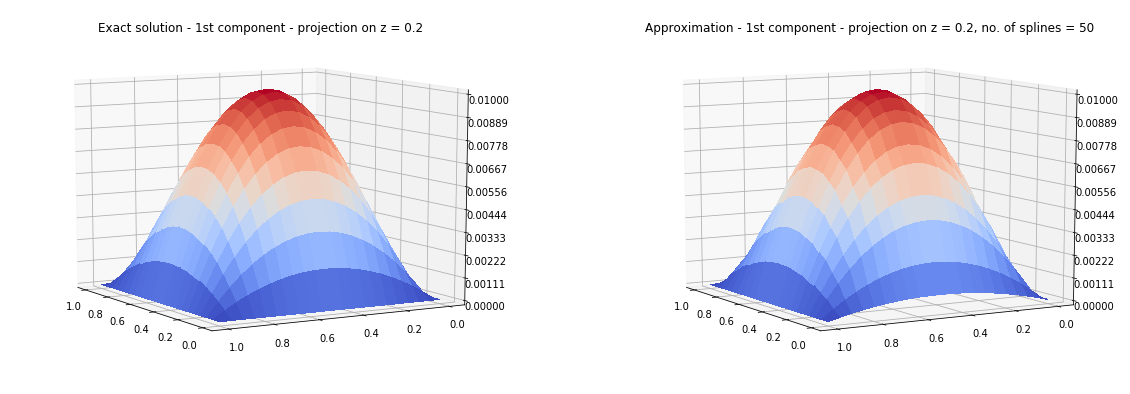

0.0006079517393864524
21


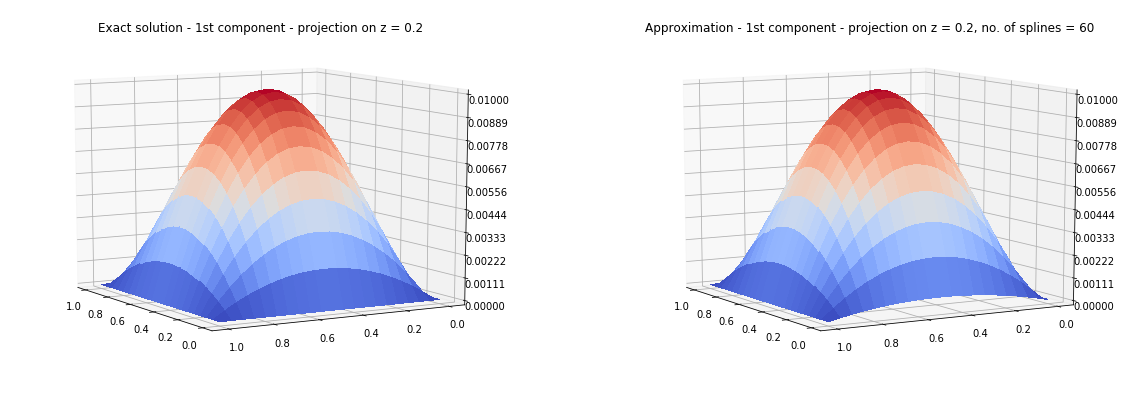

0.000457844979877567
21


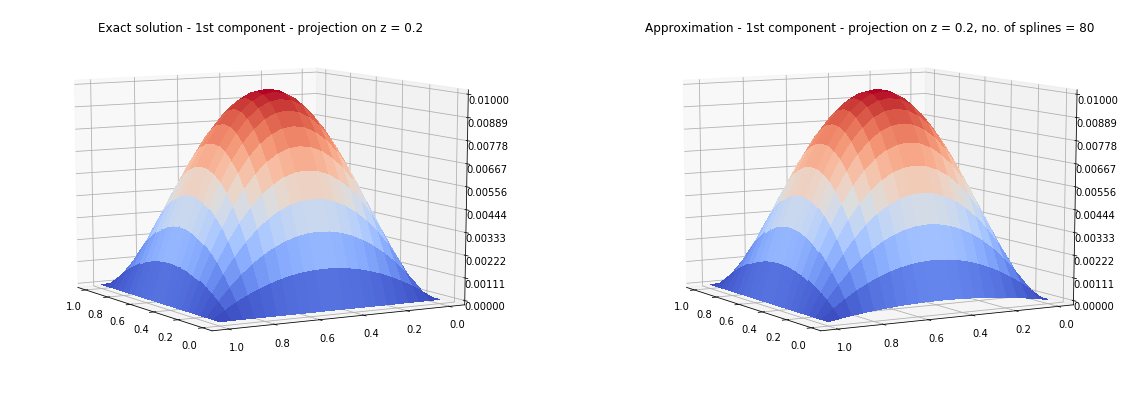

0.00040753350309767926
21


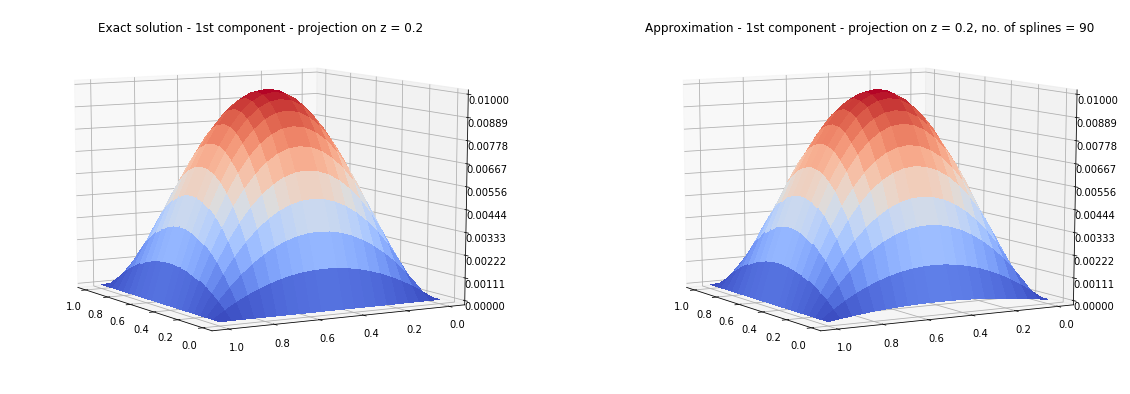

0.00036718440071140324
21


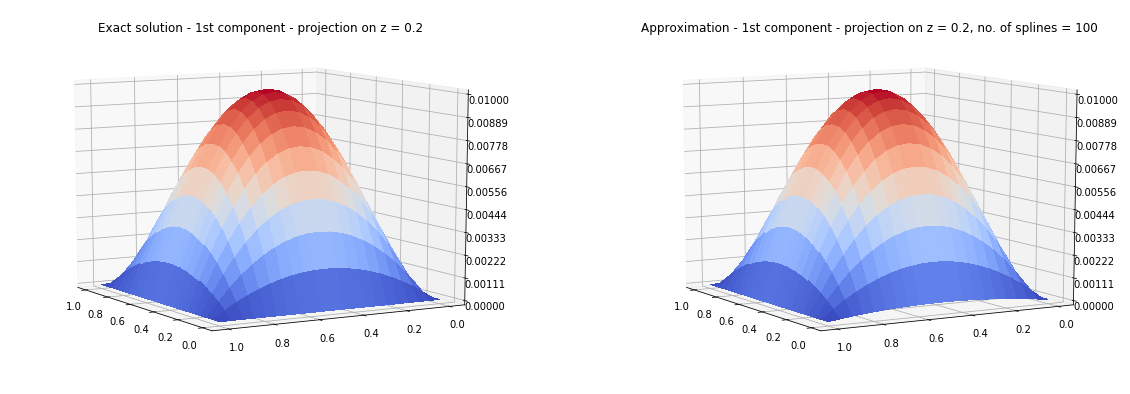

0.000334105231062878
21


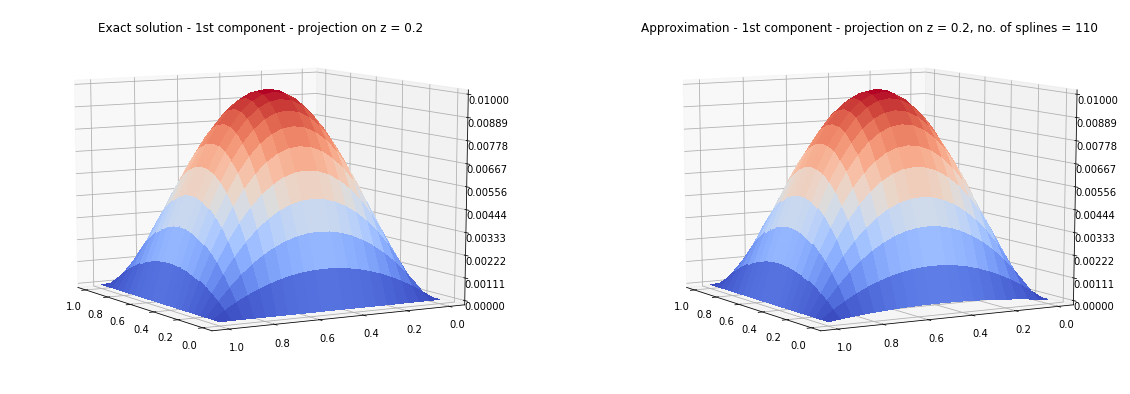

0.00030649358237803704
21


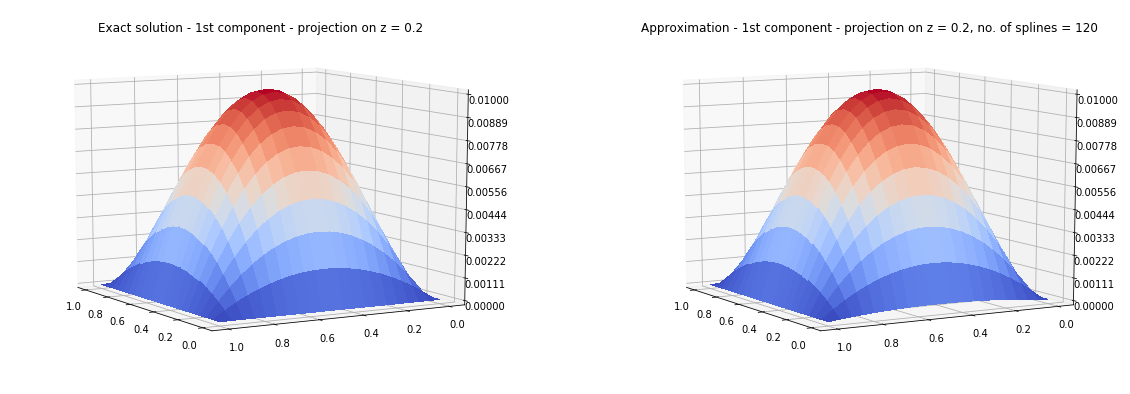

0.0002830973807962222
21


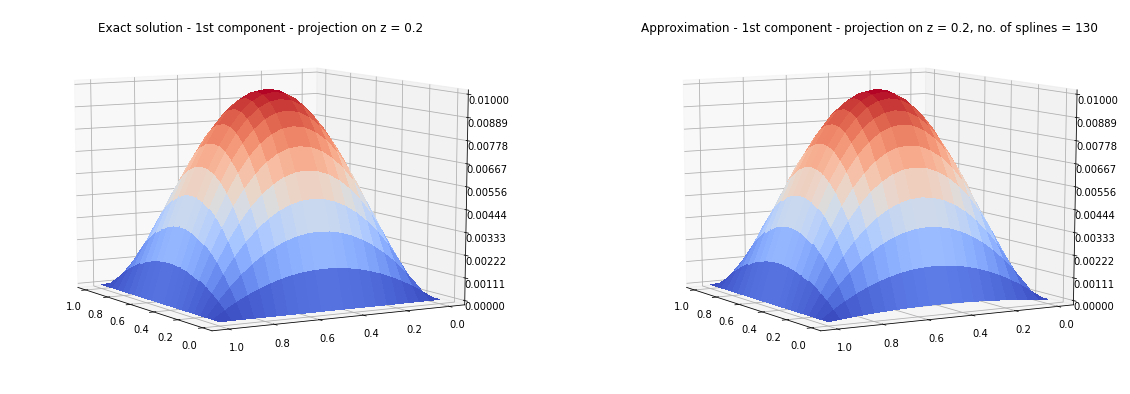

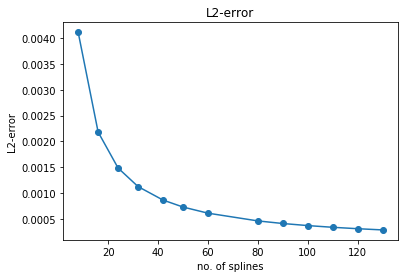

In [20]:
pp1 = PdfPages('Plots_0.pdf')
pp2 = PdfPages('L2-error.pdf')
no_of_splines = (8, 16, 24, 32, 42, 50, 60, 80, 90, 100, 110, 120, 130)
er = []

for n in no_of_splines:
    
    nx, ny, nz = (n, n, n) #Choose number of basis functions on each axis
    x = np.linspace(0, 1, nx + 2) #knots: nx+k+1 (k = 1, i.e. linear splines/ hat functions)
    y = np.linspace(0, 1, ny + 2)
    z = np.linspace(0, 1, nz + 2)
    a1 = np.identity(nx + 2)
    a2 = np.identity(ny + 2)
    a3 = np.identity(nz + 2)
    h1 = x[1] - x[0]
    h2 = y[1] - y[0]
    h3 = z[1] - z[0]
    x_0 = np.concatenate(([- h1], x, [1 + h1]))
    y_0 = np.concatenate(([- h2], y, [1 + h2]))
    z_0 = np.concatenate(([- h3], z, [1 + h3]))
    
    
    
    X, Y, Z = np.meshgrid(x, y, z)
    Xm = (X[:-1,:-1,:-1] + X[1:,1:,1:]) / 2
    Ym = (Y[:-1,:-1,:-1] + Y[1:,1:,1:]) / 2
    Zm = (Z[:-1,:-1,:-1] + Z[1:,1:,1:]) / 2
    
    
    
    E = lambda x, y, z: [(1 - x) * (1 - y) * (1 - z) * x * y * z, (1 - x) * (1 - y) * (1 - z) * x * y * z, (1 - x) * (1 - y) * (1 - z) * x * y * z]

    J = lambda x, y, z: [(1 - x) * (1 - y) * (1 - z) * x * y * z + y * (y - 1) * (2 * x ** 2 - 4 * x * z + 2 * z - 1) 
                         + z * (z - 1) * (2 * x ** 2 - 4 * x * y + 2 * y - 1), 
                         (1 - x) * (1 - y) * (1 - z) * x * y * z + x * (x - 1) * (2 * y ** 2 - 4 * y * z + 2 * z - 1)
                         - z * (z - 1) * (4 * x * y - 2 * x - 2 * y ** 2 + 1), 
                         (1 - x) * (1 - y) * (1 - z) * x * y * z - x * (x - 1) * (4 * y * z - 2 * y - 2 * z ** 2 + 1) 
                         - y * (y - 1) * (4 * x * z - 2 * x - 2 * z ** 2 + 1)]

    def basisfct(x1, x2, x3, i1, i2, i3): #Choose 1<=i1<=nx, 1<=i2<=ny, 1<=i3<=nz
        if i1 < 1 or i1 > nx:
            def spl1(t):
                return 0
        else:
            spl1 = BSpline(x_0, a1[i1, :], 1)
        if i2 < 1 or i2 > ny:
            def spl2(t):
                return 0
        else:
            spl2 = BSpline(y_0, a2[i2, :], 1)
        if i1 < 1 or i1 > nx:
            def spl3(t):
                return 0
        else:    
            spl3 = BSpline(z_0, a3[i3, :], 1)

        def Dspl1(t, i1):
            if i1 < 1 or i1 > nx:
                return 0
            else:
                if x[i1 - 1] > t or t >= x[i1]: #Numbering of Dspl functions starts from 0, whereas the numbering of the b-spline functions starts from 1
                    return 0
                else:
                    return 1 / h1

        def Dspl2(t, i2):
            if i2 < 1 or i2 > ny:
                return 0
            else:
                if y[i2 - 1] > t or t >= y[i2]:
                    return 0
                else:
                    return 1 / h2

        def Dspl3(t, i3):
            if i3 < 1 or i3 > nz:
                return 0
            else:
                if z[i3 - 1] > t or t >= z[i3]:
                    return 0
                else:
                    return 1 / h3

        return ([Dspl1(x1, i1) * spl2(x2) * spl3(x3), spl1(x1) * Dspl2(x2, i2) * spl3(x3), spl1(x1) * spl2(x2) * Dspl3(x3, i3)])
    
    
    b = h1 ** 2 / 4 * (J(Xm[:-1, :-1, :-1], Ym[:-1, :-1, :-1], Zm[:-1, :-1, :-1])[0] + J(Xm[:-1, :-1, :-1], Ym[:-1, :-1, :-1], Zm[1:, 1:, 1:])[0]
                   + J(Xm[:-1, :-1, :-1], Ym[1:, 1:, 1:], Zm[:-1, :-1, :-1])[0] + J(Xm[:-1, :-1, :-1], Ym[1:, 1:, 1:], Zm[1:, 1:, 1:])[0]
                    
                   + J(Xm[:-1, :-1, :-1], Ym[:-1, :-1, :-1], Zm[:-1, :-1, :-1])[1] + J(Xm[:-1, :-1, :-1], Ym[:-1, :-1, :-1], Zm[1:, 1:, 1:])[1]
                   + J(Xm[1:, 1:, 1:], Ym[:-1, :-1, :-1], Zm[:-1, :-1, :-1])[1] + J(Xm[1:, 1:, 1:], Ym[:-1, :-1, :-1], Zm[1:, 1:, 1:])[1]
                   
                   + J(Xm[:-1, :-1, :-1], Ym[:-1, :-1, :-1], Zm[:-1, :-1, :-1])[2] + J(Xm[1:, 1:, 1:], Ym[:-1, :-1, :-1], Zm[:-1, :-1, :-1])[2]
                   + J(Xm[:-1, :-1, :-1], Ym[1:, 1:, 1:], Zm[:-1, :-1, :-1])[2] + J(Xm[1:, 1:, 1:], Ym[1:, 1:, 1:], Zm[:-1, :-1, :-1])[2])

    b_vector = np.reshape(b, nx * ny * nz)
    
    
    
    row = []
    col = []
    data = []

    for i in range(0, nx):
        for j in range(0, ny):
            for k in range(0, nz):

                row.append(nz * (i * ny + j) + k)
                col.append(nz * (i * ny + j) + k)
                data.append(4 / 9 * (h2 * h3 / h1  + h1 * h3 / h2  + h1 * h2 / h3) + 4 / 3 * (h1 / (h2 * h3) + h2 / (h1 * h3) + h3 / (h1 * h2)))

                if j != ny - 1:
                    row.append(nz * (i * ny + j) + k) 
                    col.append(nz * (i * ny + j + 1) + k)
                    data.append(1 / 9 * (h2 * h3 / h1  + h1 * h2 / h3) + h2 / (3 * h1 * h3))

                    if k != nz - 1:
                        row.append(nz * (i * ny + j) + k)
                        col.append(nz * (i * ny + j + 1) + k + 1)
                        data.append(1 / 36 * h2 * h3 / h1)

                if j != 0:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * (i * ny + j - 1) + k)
                    data.append(1 / 9 * (h2 * h3 / h1  + h1 * h2 / h3) + h2 / (3 * h1 * h3))

                    if k != 0:
                        row.append(nz * (i * ny + j) + k)
                        col.append(nz * (i * ny + j - 1) + k - 1)
                        data.append(1 / 36 * h2 * h3 / h1)

                if k != nz - 1:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * (i * ny + j) + k + 1)
                    data.append(1 / 9 * (h2 * h3 / h1  + h1 * h3 / h2) + h3 / (3 * h1 * h2))

                if k != 0:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * (i * ny + j) + k - 1)
                    data.append(1 / 9 * (h2 * h3 / h1  + h1 * h3 / h2) + h3 / (3 * h1 * h2))

                if i != nx - 1:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i + 1) * ny + j) + k)
                    data.append(1 / 9 * (h1 * h3 / h2  + h1 * h2 / h3) + h1 / (3 * h2 * h3))

                    if j != ny - 1 and k != 0:
                        row.append(nz * (i * ny + j) + k)
                        col.append(nz * ((i + 1) * ny + j + 1) + k - 1)
                        data.append(- 1 / 6 * (h1 / (h2 * h3) + h2 / (h1 * h3)))
                    if j != 0:
                        row.append(nz * (i * ny + j) + k)
                        col.append(nz * ((i + 1) * ny + j - 1) + k)
                        data.append(1 / 36 * h1 * h2 / h3 - 2 / 3 * h3 / (h1 * h2))

                        if k != nz - 1:
                            row.append(nz * (i * ny + j) + k)
                            col.append(nz * ((i + 1) * ny + j - 1) + k + 1)
                            data.append(- 1 / 6 * (h1 / (h2 * h3) + h3 / (h1 * h2)))
                        if k != 0:
                            row.append(nz * (i * ny + j) + k)
                            col.append(nz * ((i + 1) * ny + j - 1) + k - 1)
                            data.append(- 1 / 6 * (h2 / (h1 * h3) + h3 / (h1 * h2)))
                    if k != 0:
                        row.append(nz * (i * ny + j) + k)
                        col.append(nz * ((i + 1) * ny + j) + k - 1)
                        data.append(1 / 36 * h1 * h3 / h2 - 2 / 3 * h2 / (h1 * h3))

                    if k != nz - 1:
                        row.append(nz * (i * ny + j) + k)
                        col.append(nz * ((i + 1) * ny + j) + k + 1)
                        data.append(1 / 36 * h1 * h3 / h2)

                    if j != ny - 1:
                        row.append(nz * (i * ny + j) + k)
                        col.append(nz * ((i + 1) * ny + j + 1) + k)
                        data.append(1 / 36 * h1 * h2 / h3)


                if i != 0:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i - 1) * ny + j) + k)
                    data.append(1 / 9 * (h1 * h3 / h2  + h1 * h2 / h3) + h1 / (3 * h2 * h3))

                    if j != ny - 1:
                        row.append(nz * (i * ny + j) + k)
                        col.append(nz * ((i - 1) * ny + j + 1) + k)
                        data.append(1 / 36 * h1 * h2 / h3 - 2 / 3 * h3 / (h1 * h2))

                        if k != 0:
                            row.append(nz * (i * ny + j) + k)
                            col.append(nz * ((i - 1) * ny + j + 1) + k - 1)
                            data.append(- 1 / 6 * (h1 / (h2 * h3) + h3 / (h1 * h2)))
                        if k != nz - 1:
                            row.append(nz * (i * ny + j) + k)
                            col.append(nz * ((i - 1) * ny + j + 1) + k + 1)
                            data.append(- 1 / 6 * (h2 / (h1 * h3) + h3 / (h1 * h2)))
                    if k != nz - 1:
                        row.append(nz * (i * ny + j) + k)
                        col.append(nz * ((i - 1) * ny + j) + k + 1)
                        data.append(1 / 36 * h1 * h3 / h2 - 2 / 3 * h2 / (h1 * h3))

                    if j != 0 and k != nz - 1:
                        row.append(nz * (i * ny + j) + k)
                        col.append(nz * ((i - 1) * ny + j - 1) + k + 1)
                        data.append(- 1 / 6 * (h1 / (h2 * h3) + h2 / (h1 * h3)))
                    if k != 0:
                        row.append(nz * (i * ny + j) + k)
                        col.append(nz * ((i - 1) * ny + j) + k - 1)
                        data.append(1 / 36 * h1 * h3 / h2)

                    if j != 0:
                        row.append(nz * (i * ny + j) + k)
                        col.append(nz * ((i - 1) * ny + j - 1) + k)
                        data.append(1 / 36 * h1 * h2 / h3)

                if j != 0 and k != nz - 1:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * (i * ny + j - 1) + k + 1)
                    data.append(1 / 36 * h2 * h3 / h1  - 2 / 3 * h1 / (h2 * h3))

                if j != ny - 1 and k != 0:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * (i * ny + j + 1) + k - 1)
                    data.append(1 / 36 * h2 * h3 / h1 - 2 / 3 * h1 / (h2 * h3))
                
    row = np.array(row)
    col = np.array(col)
    data = np.array(data)
    
    
    
    Syst_matrix = coo_matrix((data, (row, col)))
    u = cg(Syst_matrix.tocsc(), b_vector)
    u = u[0]
    

    
    
    u_tensor = np.reshape(u, (nx, ny, nz))
    def solution(x1, x2, x3):
        s = 0
        if x1 == 0:
            i = 1
        else:
            if x1 >= x[nx]:
                i = nx
            else:
                i = np.nonzero([x >= x1])[1][0]

        if x2 == 0:
            j = 1
        else:
            if x2 >= y[ny]:
                j = ny
            else:
                j = np.nonzero([y >= x2])[1][0]

        if x3 == 0:
            k = 1
        else:
            if x3 >= z[nz]:
                k = nz
            else:
                k = np.nonzero([z >= x3])[1][0]

        s = np.multiply(u_tensor[i - 1, j - 2, k - 2] if (0 <= i - 1 <= nx - 1 and 0 <= j - 2 <= ny - 1 and 0 <= k - 2 <= nz - 1) else 0, basisfct(x1, x2, x3, i, j - 1, k - 1))\
            + np.multiply(u_tensor[i - 1, j - 2, k - 1] if (0 <= i - 1 <= nx - 1 and 0 <= j - 2 <= ny - 1 and 0 <= k - 1 <= nz - 1) else 0, basisfct(x1, x2, x3, i, j - 1, k))\
            + np.multiply(u_tensor[i - 1, j - 2, k] if (0 <= i - 1 <= nx - 1 and 0 <= j - 2 <= ny - 1 and 0 <= k <= nz - 1) else 0, basisfct(x1, x2, x3, i, j - 1, k + 1))\
            + np.multiply(u_tensor[i - 1, j - 1, k - 2] if (0 <= i - 1 <= nx - 1 and 0 <= j - 1 <= ny - 1 and 0 <= k - 2 <= nz - 1) else 0, basisfct(x1, x2, x3, i, j, k - 1))\
            + np.multiply(u_tensor[i - 1, j - 1, k - 1] if (0 <= i - 1 <= nx - 1 and 0 <= j - 1 <= ny - 1 and 0 <= k - 1 <= nz - 1) else 0, basisfct(x1, x2, x3, i, j, k))\
            + np.multiply(u_tensor[i - 1, j - 1, k] if (0 <= i - 1 <= nx - 1 and 0 <= j - 1 <= ny - 1 and 0 <= k <= nz - 1) else 0, basisfct(x1, x2, x3, i, j, k + 1))\
            + np.multiply(u_tensor[i - 1, j, k - 2] if (0 <= i - 1 <= nx - 1 and 0 <= j <= ny - 1 and 0 <= k - 2 <= nz - 1) else 0, basisfct(x1, x2, x3, i, j + 1, k - 1))\
            + np.multiply(u_tensor[i - 1, j, k - 1] if (0 <= i - 1 <= nx - 1 and 0 <= j <= ny - 1 and 0 <= k - 1 <= nz - 1) else 0, basisfct(x1, x2, x3, i, j + 1, k))\
            + np.multiply(u_tensor[i - 1, j, k] if (0 <= i - 1 <= nx - 1 and 0 <= j <= ny - 1 and 0 <= k <= nz - 1) else 0, basisfct(x1, x2, x3, i, j + 1, k + 1))\
            + np.multiply(u_tensor[i - 2, j - 1, k - 2] if (0 <= i - 2 <= nx - 1 and 0 <= j - 1 <= ny - 1 and 0 <= k - 2 <= nz - 1) else 0, basisfct(x1, x2, x3, i - 1, j, k - 1))\
            + np.multiply(u_tensor[i, j - 1, k - 2] if (0 <= i <= nx - 1 and 0 <= j - 1 <= ny - 1 and 0 <= k - 2 <= nz - 1) else 0, basisfct(x1, x2, x3, i + 1, j, k - 1))\
            + np.multiply(u_tensor[i - 2, j - 1, k - 1] if (0 <= i - 2 <= nx - 1 and 0 <= j - 1 <= ny - 1 and 0 <= k - 1 <= nz - 1) else 0, basisfct(x1, x2, x3, i - 1, j, k))\
            + np.multiply(u_tensor[i, j - 1, k - 1] if (0 <= i <= nx - 1 and 0 <= j - 1 <= ny - 1 and 0 <= k - 1 <= nz - 1) else 0, basisfct(x1, x2, x3, i + 1, j, k))\
            + np.multiply(u_tensor[i - 2, j - 1, k] if (0 <= i - 2 <= nx - 1 and 0 <= j - 1 <= ny - 1 and 0 <= k <= nz - 1) else 0, basisfct(x1, x2, x3, i - 1, j, k + 1))\
            + np.multiply(u_tensor[i, j - 1, k] if (0 <= i <= nx - 1 and 0 <= j - 1 <= ny - 1 and 0 <= k <= nz - 1) else 0, basisfct(x1, x2, x3, i + 1, j, k + 1))\
            + np.multiply(u_tensor[i - 2, j - 2, k - 1] if (0 <= i - 2 <= nx - 1 and 0 <= j - 2 <= ny - 1 and 0 <= k - 1 <= nz - 1) else 0, basisfct(x1, x2, x3, i - 1, j - 1, k))\
            + np.multiply(u_tensor[i - 2, j, k - 1] if (0 <= i - 2 <= nx - 1 and 0 <= j <= ny - 1 and 0 <= k - 1 <= nz - 1) else 0, basisfct(x1, x2, x3, i - 1, j + 1, k))\
            + np.multiply(u_tensor[i, j - 2, k - 1] if (0 <= i <= nx - 1 and 0 <= j - 2 <= ny - 1 and 0 <= k - 1 <= nz - 1) else 0, basisfct(x1, x2, x3, i + 1, j - 1, k))\
            + np.multiply(u_tensor[i, j, k - 1] if (0 <= i <= nx - 1 and 0 <= j <= ny - 1 and 0 <= k - 1 <= nz - 1) else 0, basisfct(x1, x2, x3, i + 1, j + 1, k))\

        return s
    
    #print(u_tensor)
    
    
    
    
    row1 = []
    col1 = []
    data1 = []
    row2 = []
    col2 = []
    data2 = []
    row3 = []
    col3 = []
    data3 = []

    for i in range(0, nx):
        for j in range(0, ny):
            for k in range(0, nz):

                row1.append(nz * (i * ny + j) + k)
                col1.append(nz * (i * ny + j) + k)
                data1.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j) + k] * 4 / 9 * h2 * h3 / h1)
                row2.append(nz * (i * ny + j) + k)
                col2.append(nz * (i * ny + j) + k)
                data2.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j) + k] * 4 / 9 * h1 * h3 / h2)
                row3.append(nz * (i * ny + j) + k)
                col3.append(nz * (i * ny + j) + k)
                data3.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j) + k] * 4 / 9 * h1 * h2 / h3)

                if j != ny - 1:
                    row1.append(nz * (i * ny + j) + k)
                    col1.append(nz * (i * ny + j + 1) + k)
                    data1.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j + 1) + k] * 1 / 9 * h2 * h3 / h1)
                    row3.append(nz * (i * ny + j) + k)
                    col3.append(nz * (i * ny + j + 1) + k)
                    data3.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j + 1) + k] * 1 / 9 * h1 * h2 / h3)

                    if k != nz - 1:
                        row1.append(nz * (i * ny + j) + k)
                        col1.append(nz * (i * ny + j + 1) + k + 1)
                        data1.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j + 1) + k + 1] * 1 / 36 * h2 * h3 / h1)
                if j != 0:
                    row1.append(nz * (i * ny + j) + k)
                    col1.append(nz * (i * ny + j - 1) + k)
                    data1.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j - 1) + k] * 1 / 9 * h2 * h3 / h1)
                    row3.append(nz * (i * ny + j) + k)
                    col3.append(nz * (i * ny + j - 1) + k)
                    data3.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j - 1) + k] * 1 / 9 * h1 * h2 / h3)

                    if k != 0:
                        row1.append(nz * (i * ny + j) + k)
                        col1.append(nz * (i * ny + j - 1) + k - 1)
                        data1.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j - 1) + k - 1] * 1 / 36 * h2 * h3 / h1)
                if k != nz - 1:
                    row1.append(nz * (i * ny + j) + k)
                    col1.append(nz * (i * ny + j) + k + 1)
                    data1.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j) + k + 1] * 1 / 9 * h2 * h3 / h1)
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * (i * ny + j) + k + 1)
                    data2.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j) + k + 1] * 1 / 9 * h1 * h3 / h2)

                if k != 0:
                    row1.append(nz * (i * ny + j) + k)
                    col1.append(nz * (i * ny + j) + k - 1)
                    data1.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j) + k - 1] * 1 / 9 * h2 * h3 / h1)
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * (i * ny + j) + k - 1)
                    data2.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j) + k - 1] * 1 / 9 * h1 * h3 / h2)

                if i != nx - 1:
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * ((i + 1) * ny + j) + k)
                    data2.append(u[nz * (i * ny + j) + k] * u[nz * ((i + 1) * ny + j) + k] * 1 / 9 * h1 * h3 / h2)
                    row3.append(nz * (i * ny + j) + k)
                    col3.append(nz * ((i + 1) * ny + j) + k)
                    data3.append(u[nz * (i * ny + j) + k] * u[nz * ((i + 1) * ny + j) + k] * 1 / 9 * h1 * h2 / h3)
                    if j != 0:
                        row3.append(nz * (i * ny + j) + k)
                        col3.append(nz * ((i + 1) * ny + j - 1) + k)
                        data3.append(u[nz * (i * ny + j) + k] * u[nz * ((i + 1) * ny + j - 1) + k] * 1 / 36 * h1 * h2 / h3)
                    if k != 0:
                        row2.append(nz * (i * ny + j) + k)
                        col2.append(nz * ((i + 1) * ny + j) + k - 1)
                        data2.append(u[nz * (i * ny + j) + k] * u[nz * ((i + 1) * ny + j) + k - 1] * 1 / 36 * h1 * h3 / h2)
                    if k != nz - 1:
                        row2.append(nz * (i * ny + j) + k)
                        col2.append(nz * ((i + 1) * ny + j) + k + 1)
                        data2.append(u[nz * (i * ny + j) + k] * u[nz * ((i + 1) * ny + j) + k + 1] * 1 / 36 * h1 * h3 / h2)
                    if j != ny - 1:
                        row3.append(nz * (i * ny + j) + k)
                        col3.append(nz * ((i + 1) * ny + j + 1) + k)
                        data3.append(u[nz * (i * ny + j) + k] * u[nz * ((i + 1) * ny + j + 1) + k] * 1 / 36 * h1 * h2 / h3)

                if i != 0:
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * ((i - 1) * ny + j) + k)
                    data2.append(u[nz * (i * ny + j) + k] * u[nz * ((i - 1) * ny + j) + k] * 1 / 9 * h1 * h3 / h2)
                    row3.append(nz * (i * ny + j) + k)
                    col3.append(nz * ((i - 1) * ny + j) + k)
                    data3.append(u[nz * (i * ny + j) + k] * u[nz * ((i - 1) * ny + j) + k] * 1 / 9 * h1 * h2 / h3)
                    if j != ny - 1:
                        row3.append(nz * (i * ny + j) + k)
                        col3.append(nz * ((i - 1) * ny + j + 1) + k)
                        data3.append(u[nz * (i * ny + j) + k] * u[nz * ((i - 1) * ny + j + 1) + k] * 1 / 36 * h1 * h2 / h3)
                    if k != nz - 1:
                        row2.append(nz * (i * ny + j) + k)
                        col2.append(nz * ((i - 1) * ny + j) + k + 1)
                        data2.append(u[nz * (i * ny + j) + k] * u[nz * ((i - 1) * ny + j) + k + 1] * 1 / 36 * h1 * h3 / h2)
                    if k != 0:
                        row2.append(nz * (i * ny + j) + k)
                        col2.append(nz * ((i - 1) * ny + j) + k - 1)
                        data2.append(u[nz * (i * ny + j) + k] * u[nz * ((i - 1) * ny + j) + k - 1] * 1 / 36 * h1 * h3 / h2)
                    if j != 0:
                        row3.append(nz * (i * ny + j) + k)
                        col3.append(nz * ((i - 1) * ny + j - 1) + k)
                        data3.append(u[nz * (i * ny + j) + k] * u[nz * ((i - 1) * ny + j - 1) + k] * 1 / 36 * h1 * h2 / h3)

                if j != 0 and k != nz - 1:
                    row1.append(nz * (i * ny + j) + k)
                    col1.append(nz * (i * ny + j - 1) + k + 1)
                    data1.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j - 1) + k + 1] * 1 / 36 * h2 * h3 / h1)

                if j != ny - 1 and k != 0:
                    row1.append(nz * (i * ny + j) + k)
                    col1.append(nz * (i * ny + j + 1) + k - 1)
                    data1.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j + 1) + k - 1] * 1 / 36 * h2 * h3 / h1)

    row1 = np.array(row1)
    col1 = np.array(col1)
    data1 = np.array(data1)
    row2 = np.array(row2)
    col2 = np.array(col2)
    data2 = np.array(data2)
    row3 = np.array(row3)
    col3 = np.array(col3)
    data3 = np.array(data3)
    int_Eh_squared_1 = coo_matrix((data1, (row1, col1)))
    int_Eh_squared_2 = coo_matrix((data2, (row2, col2)))
    int_Eh_squared_3 = coo_matrix((data3, (row3, col3)))
    #print(int_Eh_squared_1.tocsc().sum())
    
    
    
    int_twoab1 = h1 ** 2 / 2 * u_tensor * (E(Xm[:-1, :-1, :-1], Ym[:-1, :-1, :-1], Zm[:-1, :-1, :-1])[0] + E(Xm[:-1, :-1, :-1], Ym[:-1, :-1, :-1], Zm[1:, 1:, 1:])[0]
                       + E(Xm[:-1, :-1, :-1], Ym[1:, 1:, 1:], Zm[:-1, :-1, :-1])[0] + E(Xm[:-1, :-1, :-1], Ym[1:, 1:, 1:], Zm[1:, 1:, 1:])[0])
                    
    int_twoab2 = h2 ** 2 / 2 * u_tensor * (E(Xm[:-1, :-1, :-1], Ym[:-1, :-1, :-1], Zm[:-1, :-1, :-1])[1] + E(Xm[:-1, :-1, :-1], Ym[:-1, :-1, :-1], Zm[1:, 1:, 1:])[1]
                       + E(Xm[1:, 1:, 1:], Ym[:-1, :-1, :-1], Zm[:-1, :-1, :-1])[1] + E(Xm[1:, 1:, 1:], Ym[:-1, :-1, :-1], Zm[1:, 1:, 1:])[1])

    int_twoab3 = h3 ** 2 / 2 * u_tensor * (E(Xm[:-1, :-1, :-1], Ym[:-1, :-1, :-1], Zm[:-1, :-1, :-1])[2] + E(Xm[1:, 1:, 1:], Ym[:-1, :-1, :-1], Zm[:-1, :-1, :-1])[2]
                       + E(Xm[:-1, :-1, :-1], Ym[1:, 1:, 1:], Zm[:-1, :-1, :-1])[2] + E(Xm[1:, 1:, 1:], Ym[1:, 1:, 1:], Zm[:-1, :-1, :-1])[2])

    #print(np.sum(int_twoab1))
    
    
    
    int_E_squared_1 = h1 * h2 * h3 * E(Xm, Ym, Zm)[0] ** 2
    int_E_squared_2 = h1 * h2 * h3 * E(Xm, Ym, Zm)[1] ** 2
    int_E_squared_3 = h1 * h2 * h3 * E(Xm, Ym, Zm)[2] ** 2
    #print(np.sum(int_E_squared_1))
    
    
    
    error = np.sqrt(np.sum(int_E_squared_1) + int_Eh_squared_1.tocsc().sum() - np.sum(int_twoab1))\
            + np.sqrt(np.sum(int_E_squared_2) + int_Eh_squared_2.tocsc().sum() - np.sum(int_twoab2))\
            + np.sqrt(np.sum(int_E_squared_3) + int_Eh_squared_3.tocsc().sum() - np.sum(int_twoab3))
    print(error)
    er.append(error)

    


    def ff(x,y):
        v = np.zeros(len(x))
        for i in range(0,len(x)):
            v[i] = solution(x[i],y[i],0.2)[0]
        return(v)

    X = np.arange(0, 1.05, 0.05)
    Y = np.arange(0, 1.05, 0.05)
    X, Y = np.meshgrid(X, Y)
    print(len(X))
    Z = E(X,Y,0.2)[0]
    #print(Z)
    Z2 = np.zeros(shape = (len(X),len(X)))
    for k in range(0, len(X)):
        Z2[k] = ff(X[k],Y[k])
        
        
    

    
    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, subplot_kw = {"projection": "3d"}, figsize=(20, 7))

    surf1 = ax1.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    surf2 = ax2.plot_surface(X, Y, Z2, cmap=cm.coolwarm,linewidth=0, antialiased=False)

    # Customize the z axis.
    ax1.set_zlim(0, 0.01)
    ax1.zaxis.set_major_locator(LinearLocator(10))
    #ax.zaxis.set_major_formatter('{x:.02f}')
    ax1.view_init(10, 150)
    ax1.set_title('Exact solution - 1st component - projection on z = 0.2')
    #fig.colorbar(surf1, shrink=0.5, aspect=5)

    # Customize the z axis.
    ax2.set_zlim(0, 0.01)
    ax2.zaxis.set_major_locator(LinearLocator(10))
    #ax.zaxis.set_major_formatter('{x:.02f}')
    ax2.view_init(10, 150)
    ax2.set_title('Approximation - 1st component - projection on z = 0.2, no. of splines = %d' % n)
    #fig.colorbar(surf2, shrink=0.5, aspect=5)
    
    fig.savefig(pp1, format='pdf') 
    plt.show()
    
    
fig1 = plt.figure()
plt.plot(no_of_splines, np.array(er),'-o')
plt.title('L2-error')
plt.xlabel('no. of splines')
plt.ylabel('L2-error')
plt.show()
    
fig1.savefig(pp2, format='pdf')
pp1.close()
pp2.close()

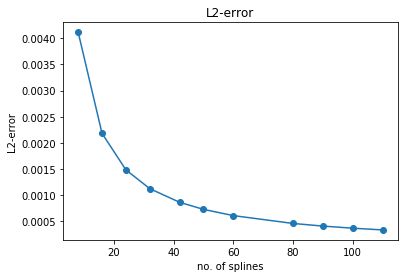

In [19]:
fig1 = plt.figure()
plt.plot(no_of_splines, np.array(er),'-o')
plt.title('L2-error')
plt.xlabel('no. of splines')
plt.ylabel('L2-error')
plt.savefig('L2-error.pdf')
plt.show()

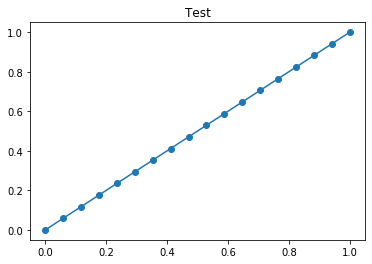

In [197]:
fig1 = plt.figure()
tz = PdfPages('a1.pdf')
    
plt.plot(x,y,'-o')
plt.title('Test')

fig1.savefig(tz, format='pdf')
tz.close()

In [ ]:
b = np.zeros(shape = (nx, ny, nz))
for i in range(0, nx):
    for j in range(0, ny):
        for k in range(0, nz):
            b[i, j, k] += h1 * h2 * h3 * (J((2 * i + 1) * h1 / 2, (2 * j + 1) * h2 / 2, (2 * k + 1) * h3 / 2)[0] * basisfct((2 * i + 1) * h1 / 2, (2 * j + 1) * h2 / 2, (2 * k + 1) * h3 / 2, i + 1, j + 1, k + 1)[0] \
                        + J((2 * i + 1) * h1 / 2, (2 * j + 1) * h2 / 2, (2 * k + 3) * h3 / 2)[0] * basisfct((2 * i + 1) * h1 / 2, (2 * j + 1) * h2 / 2, (2 * k + 3) * h3 / 2, i + 1, j + 1, k + 1)[0] \
                        + J((2 * i + 1) * h1 / 2, (2 * j + 3) * h2 / 2, (2 * k + 1) * h3 / 2)[0] * basisfct((2 * i + 1) * h1 / 2, (2 * j + 3) * h2 / 2, (2 * k + 1) * h3 / 2, i + 1, j + 1, k + 1)[0] \
                        + J((2 * i + 1) * h1 / 2, (2 * j + 3) * h2 / 2, (2 * k + 3) * h3 / 2)[0] * basisfct((2 * i + 1) * h1 / 2, (2 * j + 3) * h2 / 2, (2 * k + 3) * h3 / 2, i + 1, j + 1, k + 1)[0] \
                        + J((2 * i + 1) * h1 / 2, (2 * j + 1) * h2 / 2, (2 * k + 1) * h3 / 2)[1] * basisfct((2 * i + 1) * h1 / 2, (2 * j + 1) * h2 / 2, (2 * k + 1) * h3 / 2, i + 1, j + 1, k + 1)[1] \
                        + J((2 * i + 1) * h1 / 2, (2 * j + 1) * h2 / 2, (2 * k + 3) * h3 / 2)[1] * basisfct((2 * i + 1) * h1 / 2, (2 * j + 1) * h2 / 2, (2 * k + 3) * h3 / 2, i + 1, j + 1, k + 1)[1] \
                        + J((2 * i + 3) * h1 / 2, (2 * j + 1) * h2 / 2, (2 * k + 1) * h3 / 2)[1] * basisfct((2 * i + 3) * h1 / 2, (2 * j + 1) * h2 / 2, (2 * k + 1) * h3 / 2, i + 1, j + 1, k + 1)[1] \
                        + J((2 * i + 3) * h1 / 2, (2 * j + 1) * h2 / 2, (2 * k + 3) * h3 / 2)[1] * basisfct((2 * i + 3) * h1 / 2, (2 * j + 1) * h2 / 2, (2 * k + 3) * h3 / 2, i + 1, j + 1, k + 1)[1] \
                        + J((2 * i + 1) * h1 / 2, (2 * j + 1) * h2 / 2, (2 * k + 1) * h3 / 2)[2] * basisfct((2 * i + 1) * h1 / 2, (2 * j + 1) * h2 / 2, (2 * k + 1) * h3 / 2, i + 1, j + 1, k + 1)[2] \
                        + J((2 * i + 1) * h1 / 2, (2 * j + 3) * h2 / 2, (2 * k + 1) * h3 / 2)[2] * basisfct((2 * i + 1) * h1 / 2, (2 * j + 3) * h2 / 2, (2 * k + 1) * h3 / 2, i + 1, j + 1, k + 1)[2] \
                        + J((2 * i + 3) * h1 / 2, (2 * j + 1) * h2 / 2, (2 * k + 1) * h3 / 2)[2] * basisfct((2 * i + 3) * h1 / 2, (2 * j + 1) * h2 / 2, (2 * k + 1) * h3 / 2, i + 1, j + 1, k + 1)[2] \
                        + J((2 * i + 3) * h1 / 2, (2 * j + 3) * h2 / 2, (2 * k + 1) * h3 / 2)[2] * basisfct((2 * i + 3) * h1 / 2, (2 * j + 3) * h2 / 2, (2 * k + 1) * h3 / 2, i + 1, j + 1, k + 1)[2])
        

In [ ]:
#Build mass matrix (tensor)
#Write this shorter if h1 == h2 == h3
M = np.zeros(shape = (nx, ny, nz, nx, ny, nz))
for i in range(0, nx):
    for j in range(0, ny):
        for k in range(0, nz):
            M[i, j, k, i, j, k] = 4 / 9 * (h2 * h3 / h1  + h1 * h3 / h2  + h1 * h2 / h3)

            M[i, j, k, i + 1 if i != nx - 1 else i - 1, j, k] = M[i, j, k, i - 1 if i != 0 else i + 1, j, k] = 1 / 9 * (h1 * h3 / h2  + h1 * h2 / h3)
            M[i, j, k, i, j + 1 if j != ny - 1 else j - 1, k] = M[i, j, k, i, j - 1 if j != 0 else j + 1, k] = 1 / 9 * (h2 * h3 / h1  + h1 * h2 / h3)
            M[i, j, k, i, j, k + 1 if k != nz - 1 else k - 1] = M[i, j, k, i, j, k - 1 if k != 0 else k + 1] = 1 / 9 * (h2 * h3 / h1  + h1 * h3 / h2)

            M[i, j, k, i, j + 1 if j != ny - 1 else j - 1, k + 1 if k != nz - 1 else k - 1] = M[i, j, k, i, j - 1 if j != 0 else j + 1, k - 1 if k != 0 else k + 1] = M[i, j, k, i, j + 1 if j != ny - 1 else j - 1, k - 1 if k != 0 else k + 1] = M[i, j, k, i, j - 1 if j != 0 else j + 1, k + 1 if k != nz - 1 else k - 1] = 1 / 36 * h2 * h3 / h1 
            M[i, j, k, i + 1 if i != nx - 1 else i - 1, j, k + 1 if k != nz - 1 else k - 1] = M[i, j, k, i - 1 if i != 0 else i + 1, j, k - 1 if k != 0 else k + 1] = M[i, j, k, i + 1 if i != nx - 1 else i - 1, j, k - 1 if k != 0 else k + 1] = M[i, j, k, i - 1 if i != 0 else i + 1, j, k + 1 if k != nz - 1 else k - 1] = 1 / 36 * h1 * h3 / h2 
            M[i, j, k, i + 1 if i != nx - 1 else i - 1, j + 1 if j != ny - 1 else j - 1, k] = M[i, j, k, i - 1 if i != 0 else i + 1, j - 1 if j != 0 else j + 1, k] = M[i, j, k, i + 1 if i != nx - 1 else i - 1, j - 1 if j != 0 else j + 1, k] = M[i, j, k, i - 1 if i != 0 else i + 1, j + 1 if j != ny - 1 else j - 1, k] = 1 / 36 * h1 * h2 / h3

print(M)

In [ ]:
A = np.zeros(shape = (nx, ny, nz, nx, ny, nz))
for i in range(0, nx):
    for j in range(0, ny):
        for k in range(0, nz):
            A[i, j, k, i, j, k] = 4 / 3 * (h1 / (h2 * h3) + h2 / (h1 * h3) + h3 / (h1 * h2))

            A[i, j, k, i + 1 if i != nx - 1 else i - 1, j, k] = A[i, j, k, i - 1 if i != 0 else i + 1, j, k] = h1 / (3 * h2 * h3) 
            A[i, j, k, i, j + 1 if j != ny - 1 else j - 1, k] = A[i, j, k, i, j - 1 if j != 0 else j + 1, k] = h2 / (3 * h1 * h3) 
            A[i, j, k, i, j, k + 1 if k != nz - 1 else k - 1] = A[i, j, k, i, j, k - 1 if k != 0 else k + 1] = h3 / (3 * h1 * h2) 

            if i != nx - 1:
                if j != ny - 1 and k != 0:
                    A[i, j, k, i + 1, j + 1, k - 1] = - 1 / 6 * (h1 / (h2 * h3) + h2 / (h1 * h3))
                if j != 0:
                    A[i, j, k, i + 1, j - 1, k] = - 2 / 3 * h3 / (h1 * h2)
                    if k != nz - 1:
                        A[i, j, k, i + 1, j - 1, k + 1] = - 1 / 6 * (h1 / (h2 * h3) + h3 / (h1 * h2))
                    if k != 0:
                        A[i, j, k, i + 1, j - 1, k - 1] = - 1 / 6 * (h2 / (h1 * h3) + h3 / (h1 * h2))
                if k != 0:
                    A[i, j, k, i + 1, j, k - 1] = - 2 / 3 * h2 / (h1 * h3)
            if i != 0:
                if j != ny - 1:
                    A[i, j, k, i - 1, j + 1, k] = - 2 / 3 * h3 / (h1 * h2)
                    if k != 0:
                        A[i, j, k, i - 1, j + 1, k - 1] = - 1 / 6 * (h1 / (h2 * h3) + h3 / (h1 * h2))
                    if k != nz - 1:
                        A[i, j, k, i - 1, j + 1, k + 1] = - 1 / 6 * (h2 / (h1 * h3) + h3 / (h1 * h2))
                if k != nz - 1:
                    A[i, j, k, i - 1, j, k + 1] = - 2 / 3 * h2 / (h1 * h3)
                if j != 0 and k != nz - 1:
                    A[i, j, k, i - 1, j - 1, k + 1] = - 1 / 6 * (h1 / (h2 * h3) + h2 / (h1 * h3))
            if j != 0 and k != nz - 1:       
                A[i, j, k, i, j - 1, k + 1] = - 2 / 3 * h1 / (h2 * h3)
            if j != ny - 1 and k != 0:
                A[i, j, k, i , j + 1, k - 1] = - 2 / 3 * h1 / (h2 * h3)


print(A)

In [ ]:
M_matrix = np.reshape(M, (nx * ny * nz, nx * ny * nz))
A_matrix = np.reshape(A, (nx * ny * nz, nx * ny * nz))
b_vector = np.reshape(b, nx * ny * nz)
System_matrix = M_matrix + A_matrix
u = np.linalg.solve(System_matrix, b_vector)
#print(b_vector)
#print(np.matmul(System_matrix,u))
print(u, u1)
#print(max(abs(u)))
#print(b_vector)
#print(np.count_nonzero(System_matrix))
#print(System_matrix)
print(np.max(u),np.max(u1))

In [ ]:
'''
row1 = np.empty(0, int)
data1 = np.empty(0, int)
for i in range(0, nx):
    for j in range(0, ny):
        for k in range(0, nz):
            row1 = np.append(row1, nz * (i * ny + j) + k)
            col1 = np.append(col1, 0)
            data1 = np.append(data1, h1 * h2 * h3 * (J((2 * i + 1) * h1 / 2, (2 * j + 1) * h2 / 2, (2 * k + 1) * h3 / 2)[0] * basisfct((2 * i + 1) * h1 / 2, (2 * j + 1) * h2 / 2, (2 * k + 1) * h3 / 2, i + 1, j + 1, k + 1)[0] \
                        + J((2 * i + 1) * h1 / 2, (2 * j + 1) * h2 / 2, (2 * k + 3) * h3 / 2)[0] * basisfct((2 * i + 1) * h1 / 2, (2 * j + 1) * h2 / 2, (2 * k + 3) * h3 / 2, i + 1, j + 1, k + 1)[0] \
                        + J((2 * i + 1) * h1 / 2, (2 * j + 3) * h2 / 2, (2 * k + 1) * h3 / 2)[0] * basisfct((2 * i + 1) * h1 / 2, (2 * j + 3) * h2 / 2, (2 * k + 1) * h3 / 2, i + 1, j + 1, k + 1)[0] \
                        + J((2 * i + 1) * h1 / 2, (2 * j + 3) * h2 / 2, (2 * k + 3) * h3 / 2)[0] * basisfct((2 * i + 1) * h1 / 2, (2 * j + 3) * h2 / 2, (2 * k + 3) * h3 / 2, i + 1, j + 1, k + 1)[0] \
                        + J((2 * i + 1) * h1 / 2, (2 * j + 1) * h2 / 2, (2 * k + 1) * h3 / 2)[1] * basisfct((2 * i + 1) * h1 / 2, (2 * j + 1) * h2 / 2, (2 * k + 1) * h3 / 2, i + 1, j + 1, k + 1)[1] \
                        + J((2 * i + 1) * h1 / 2, (2 * j + 1) * h2 / 2, (2 * k + 3) * h3 / 2)[1] * basisfct((2 * i + 1) * h1 / 2, (2 * j + 1) * h2 / 2, (2 * k + 3) * h3 / 2, i + 1, j + 1, k + 1)[1] \
                        + J((2 * i + 3) * h1 / 2, (2 * j + 1) * h2 / 2, (2 * k + 1) * h3 / 2)[1] * basisfct((2 * i + 3) * h1 / 2, (2 * j + 1) * h2 / 2, (2 * k + 1) * h3 / 2, i + 1, j + 1, k + 1)[1] \
                        + J((2 * i + 3) * h1 / 2, (2 * j + 1) * h2 / 2, (2 * k + 3) * h3 / 2)[1] * basisfct((2 * i + 3) * h1 / 2, (2 * j + 1) * h2 / 2, (2 * k + 3) * h3 / 2, i + 1, j + 1, k + 1)[1] \
                        + J((2 * i + 1) * h1 / 2, (2 * j + 1) * h2 / 2, (2 * k + 1) * h3 / 2)[2] * basisfct((2 * i + 1) * h1 / 2, (2 * j + 1) * h2 / 2, (2 * k + 1) * h3 / 2, i + 1, j + 1, k + 1)[2] \
                        + J((2 * i + 1) * h1 / 2, (2 * j + 3) * h2 / 2, (2 * k + 1) * h3 / 2)[2] * basisfct((2 * i + 1) * h1 / 2, (2 * j + 3) * h2 / 2, (2 * k + 1) * h3 / 2, i + 1, j + 1, k + 1)[2] \
                        + J((2 * i + 3) * h1 / 2, (2 * j + 1) * h2 / 2, (2 * k + 1) * h3 / 2)[2] * basisfct((2 * i + 3) * h1 / 2, (2 * j + 1) * h2 / 2, (2 * k + 1) * h3 / 2, i + 1, j + 1, k + 1)[2] \
                        + J((2 * i + 3) * h1 / 2, (2 * j + 3) * h2 / 2, (2 * k + 1) * h3 / 2)[2] * basisfct((2 * i + 3) * h1 / 2, (2 * j + 3) * h2 / 2, (2 * k + 1) * h3 / 2, i + 1, j + 1, k + 1)[2]))
'''

In [ ]:
'''

row = np.empty(0, int)
col = np.empty(0, int)
data = np.empty(0, int)

for i in range(0, nx):
    for j in range(0, ny):
        for k in range(0, nz):
            
            row = np.append(row, nz * (i * ny + j) + k)
            col = np.append(col, nz * (i * ny + j) + k)
            data = np.append(data, 4 / 9 * (h2 * h3 / h1  + h1 * h3 / h2  + h1 * h2 / h3) + 4 / 3 * (h1 / (h2 * h3) + h2 / (h1 * h3) + h3 / (h1 * h2)))
            
            if j != ny - 1:
                row = np.append(row, nz * (i * ny + j) + k)
                col = np.append(col, nz * (i * ny + j + 1) + k)
                data = np.append(data, 1 / 9 * (h2 * h3 / h1  + h1 * h2 / h3) + h2 / (3 * h1 * h3))
                if k != nz - 1:
                    row = np.append(row, nz * (i * ny + j) + k)
                    col = np.append(col, nz * (i * ny + j + 1) + k + 1)
                    data = np.append(data, 1 / 36 * h2 * h3 / h1)
            if j != 0:
                row = np.append(row, nz * (i * ny + j) + k)
                col = np.append(col, nz * (i * ny + j - 1) + k)
                data = np.append(data, 1 / 9 * (h2 * h3 / h1  + h1 * h2 / h3) + h2 / (3 * h1 * h3))
                if k != 0:
                    row = np.append(row, nz * (i * ny + j) + k)
                    col = np.append(col, nz * (i * ny + j - 1) + k - 1)
                    data = np.append(data, 1 / 36 * h2 * h3 / h1)
            if k != nz - 1:
                row = np.append(row, nz * (i * ny + j) + k)
                col = np.append(col, nz * (i * ny + j) + k + 1)
                data = np.append(data, 1 / 9 * (h2 * h3 / h1  + h1 * h3 / h2) + h3 / (3 * h1 * h2))
            if k != 0:
                row = np.append(row, nz * (i * ny + j) + k)
                col = np.append(col, nz * (i * ny + j) + k - 1)
                data = np.append(data, 1 / 9 * (h2 * h3 / h1  + h1 * h3 / h2) + h3 / (3 * h1 * h2))
            
            if i != nx - 1:
                row = np.append(row, nz * (i * ny + j) + k)
                col = np.append(col, nz * ((i + 1) * ny + j) + k)
                data = np.append(data, 1 / 9 * (h1 * h3 / h2  + h1 * h2 / h3) + h1 / (3 * h2 * h3))
                if j != ny - 1 and k != 0:
                    row = np.append(row, nz * (i * ny + j) + k)
                    col = np.append(col, nz * ((i + 1) * ny + j + 1) + k - 1)
                    data = np.append(data, - 1 / 6 * (h1 / (h2 * h3) + h2 / (h1 * h3)))
                if j != 0:
                    row = np.append(row, nz * (i * ny + j) + k)
                    col = np.append(col, nz * ((i + 1) * ny + j - 1) + k)
                    data = np.append(data, 1 / 36 * h1 * h2 / h3 - 2 / 3 * h3 / (h1 * h2))
                    if k != nz - 1:
                        row = np.append(row, nz * (i * ny + j) + k)
                        col = np.append(col, nz * ((i + 1) * ny + j - 1) + k + 1)
                        data = np.append(data, - 1 / 6 * (h1 / (h2 * h3) + h3 / (h1 * h2)))
                    if k != 0:
                        row = np.append(row, nz * (i * ny + j) + k)
                        col = np.append(col, nz * ((i + 1) * ny + j - 1) + k - 1)
                        data = np.append(data, - 1 / 6 * (h2 / (h1 * h3) + h3 / (h1 * h2)))
                if k != 0:
                    row = np.append(row, nz * (i * ny + j) + k)
                    col = np.append(col, nz * ((i + 1) * ny + j) + k - 1)
                    data = np.append(data, 1 / 36 * h1 * h3 / h2 - 2 / 3 * h2 / (h1 * h3))
                if k != nz - 1:
                    row = np.append(row, nz * (i * ny + j) + k)
                    col = np.append(col, nz * ((i + 1) * ny + j) + k + 1)
                    data = np.append(data, 1 / 36 * h1 * h3 / h2)
                if j != ny - 1:
                    row = np.append(row, nz * (i * ny + j) + k)
                    col = np.append(col, nz * ((i + 1) * ny + j + 1) + k)
                    data = np.append(data, 1 / 36 * h1 * h2 / h3)
            
            if i != 0:
                row = np.append(row, nz * (i * ny + j) + k)
                col = np.append(col, nz * ((i - 1) * ny + j) + k)
                data = np.append(data, 1 / 9 * (h1 * h3 / h2  + h1 * h2 / h3) + h1 / (3 * h2 * h3))
                if j != ny - 1:
                    row = np.append(row, nz * (i * ny + j) + k)
                    col = np.append(col, nz * ((i - 1) * ny + j + 1) + k)
                    data = np.append(data, 1 / 36 * h1 * h2 / h3 - 2 / 3 * h3 / (h1 * h2))
                    if k != 0:
                        row = np.append(row, nz * (i * ny + j) + k)
                        col = np.append(col, nz * ((i - 1) * ny + j + 1) + k - 1)
                        data = np.append(data, - 1 / 6 * (h1 / (h2 * h3) + h3 / (h1 * h2)))
                    if k != nz - 1:
                        row = np.append(row, nz * (i * ny + j) + k)
                        col = np.append(col, nz * ((i - 1) * ny + j + 1) + k + 1)
                        data = np.append(data, - 1 / 6 * (h2 / (h1 * h3) + h3 / (h1 * h2)))
                if k != nz - 1:
                    row = np.append(row, nz * (i * ny + j) + k)
                    col = np.append(col, nz * ((i - 1) * ny + j) + k + 1)
                    data = np.append(data, 1 / 36 * h1 * h3 / h2 - 2 / 3 * h2 / (h1 * h3))
                if j != 0 and k != nz - 1:
                    row = np.append(row, nz * (i * ny + j) + k)
                    col = np.append(col, nz * ((i - 1) * ny + j - 1) + k + 1)
                    data = np.append(data, - 1 / 6 * (h1 / (h2 * h3) + h2 / (h1 * h3)))
                if k != 0:
                    row = np.append(row, nz * (i * ny + j) + k)
                    col = np.append(col, nz * ((i - 1) * ny + j) + k - 1)
                    data = np.append(data, 1 / 36 * h1 * h3 / h2)
                if j != 0:
                    row = np.append(row, nz * (i * ny + j) + k)
                    col = np.append(col, nz * ((i - 1) * ny + j - 1) + k)
                    data = np.append(data, 1 / 36 * h1 * h2 / h3)
                                  
            if j != 0 and k != nz - 1:
                row = np.append(row, nz * (i * ny + j) + k)
                col = np.append(col, nz * (i * ny + j - 1) + k + 1)
                data = np.append(data, 1 / 36 * h2 * h3 / h1  - 2 / 3 * h1 / (h2 * h3))
                                    
            if j != ny - 1 and k != 0:
                row = np.append(row, nz * (i * ny + j) + k)
                col = np.append(col, nz * (i * ny + j + 1) + k - 1)
                data = np.append(data, 1 / 36 * h2 * h3 / h1 - 2 / 3 * h1 / (h2 * h3))
                
'''

In [ ]:
'''

row2 = []
col2 = []
data2 = []

for i in range(0, nx):
    for j in range(0, ny):
        for k in range(0, nz):
            
            row.append(nz * (i * ny + j) + k)
            col.append(nz * (i * ny + j) + k)
            data.append(4 / 9 * (h2 * h3 / h1  + h1 * h3 / h2  + h1 * h2 / h3) + 4 / 3 * (h1 / (h2 * h3) + h2 / (h1 * h3) + h3 / (h1 * h2)))
            row2.append(nz * (i * ny + j) + k)
            col2.append(nz * (i * ny + j) + k)
            data2.append(4 / 9 * (h2 * h3 / h1  + h1 * h3 / h2  + h1 * h2 / h3))
            
            if j != ny - 1:
                row.append(nz * (i * ny + j) + k) 
                col.append(nz * (i * ny + j + 1) + k)
                data.append(1 / 9 * (h2 * h3 / h1  + h1 * h2 / h3) + h2 / (3 * h1 * h3))
                row2.append(nz * (i * ny + j) + k)
                col2.append(nz * (i * ny + j + 1) + k)
                data2.append(1 / 9 * (h2 * h3 / h1  + h1 * h2 / h3))
            
                if k != nz - 1:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * (i * ny + j + 1) + k + 1)
                    data.append(1 / 36 * h2 * h3 / h1)
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * (i * ny + j + 1) + k + 1)
                    data2.append(1 / 36 * h2 * h3 / h1)
            if j != 0:
                row.append(nz * (i * ny + j) + k)
                col.append(nz * (i * ny + j - 1) + k)
                data.append(1 / 9 * (h2 * h3 / h1  + h1 * h2 / h3) + h2 / (3 * h1 * h3))
                row2.append(nz * (i * ny + j) + k)
                col2.append(nz * (i * ny + j - 1) + k)
                data2.append(1 / 9 * (h2 * h3 / h1  + h1 * h2 / h3))
                
                if k != 0:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * (i * ny + j - 1) + k - 1)
                    data.append(1 / 36 * h2 * h3 / h1)
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * (i * ny + j - 1) + k - 1)
                    data2.append(1 / 36 * h2 * h3 / h1)
            if k != nz - 1:
                row.append(nz * (i * ny + j) + k)
                col.append(nz * (i * ny + j) + k + 1)
                data.append(1 / 9 * (h2 * h3 / h1  + h1 * h3 / h2) + h3 / (3 * h1 * h2))
                row2.append(nz * (i * ny + j) + k)
                col2.append(nz * (i * ny + j) + k + 1)
                data2.append(1 / 9 * (h2 * h3 / h1  + h1 * h2 / h3))
                
            if k != 0:
                row.append(nz * (i * ny + j) + k)
                col.append(nz * (i * ny + j) + k - 1)
                data.append(1 / 9 * (h2 * h3 / h1  + h1 * h3 / h2) + h3 / (3 * h1 * h2))
                row2.append(nz * (i * ny + j) + k)
                col2.append(nz * (i * ny + j) + k - 1)
                data2.append(1 / 9 * (h2 * h3 / h1  + h1 * h2 / h3))
            
            if i != nx - 1:
                row.append(nz * (i * ny + j) + k)
                col.append(nz * ((i + 1) * ny + j) + k)
                data.append(1 / 9 * (h1 * h3 / h2  + h1 * h2 / h3) + h1 / (3 * h2 * h3))
                row2.append(nz * (i * ny + j) + k)
                col2.append(nz * ((i + 1) * ny + j) + k)
                data2.append(1 / 9 * (h1 * h3 / h2  + h1 * h2 / h3))
                if j != ny - 1 and k != 0:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i + 1) * ny + j + 1) + k - 1)
                    data.append(- 1 / 6 * (h1 / (h2 * h3) + h2 / (h1 * h3)))
                if j != 0:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i + 1) * ny + j - 1) + k)
                    data.append(1 / 36 * h1 * h2 / h3 - 2 / 3 * h3 / (h1 * h2))
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * ((i + 1) * ny + j - 1) + k)
                    data2.append(1 / 36 * h1 * h2 / h3)
                    if k != nz - 1:
                        row.append(nz * (i * ny + j) + k)
                        col.append(nz * ((i + 1) * ny + j - 1) + k + 1)
                        data.append(- 1 / 6 * (h1 / (h2 * h3) + h3 / (h1 * h2)))
                    if k != 0:
                        row.append(nz * (i * ny + j) + k)
                        col.append(nz * ((i + 1) * ny + j - 1) + k - 1)
                        data.append(- 1 / 6 * (h2 / (h1 * h3) + h3 / (h1 * h2)))
                if k != 0:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i + 1) * ny + j) + k - 1)
                    data.append(1 / 36 * h1 * h3 / h2 - 2 / 3 * h2 / (h1 * h3))
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * ((i + 1) * ny + j) + k - 1)
                    data2.append(1 / 36 * h1 * h3 / h2)
                if k != nz - 1:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i + 1) * ny + j) + k + 1)
                    data.append(1 / 36 * h1 * h3 / h2)
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * ((i + 1) * ny + j) + k + 1)
                    data2.append(1 / 36 * h1 * h3 / h2)
                if j != ny - 1:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i + 1) * ny + j + 1) + k)
                    data.append(1 / 36 * h1 * h2 / h3)
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * ((i + 1) * ny + j + 1) + k)
                    data2.append(1 / 36 * h1 * h2 / h3)
            
            if i != 0:
                row.append(nz * (i * ny + j) + k)
                col.append(nz * ((i - 1) * ny + j) + k)
                data.append(1 / 9 * (h1 * h3 / h2  + h1 * h2 / h3) + h1 / (3 * h2 * h3))
                row2.append(nz * (i * ny + j) + k)
                col2.append(nz * ((i - 1) * ny + j) + k)
                data2.append(1 / 9 * (h1 * h3 / h2  + h1 * h2 / h3))
                if j != ny - 1:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i - 1) * ny + j + 1) + k)
                    data.append(1 / 36 * h1 * h2 / h3 - 2 / 3 * h3 / (h1 * h2))
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * ((i - 1) * ny + j + 1) + k)
                    data2.append(1 / 36 * h1 * h2 / h3)
                    if k != 0:
                        row.append(nz * (i * ny + j) + k)
                        col.append(nz * ((i - 1) * ny + j + 1) + k - 1)
                        data.append(- 1 / 6 * (h1 / (h2 * h3) + h3 / (h1 * h2)))
                    if k != nz - 1:
                        row.append(nz * (i * ny + j) + k)
                        col.append(nz * ((i - 1) * ny + j + 1) + k + 1)
                        data.append(- 1 / 6 * (h2 / (h1 * h3) + h3 / (h1 * h2)))
                if k != nz - 1:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i - 1) * ny + j) + k + 1)
                    data.append(1 / 36 * h1 * h3 / h2 - 2 / 3 * h2 / (h1 * h3))
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * ((i - 1) * ny + j) + k + 1)
                    data2.append(1 / 36 * h1 * h3 / h2)
                if j != 0 and k != nz - 1:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i - 1) * ny + j - 1) + k + 1)
                    data.append(- 1 / 6 * (h1 / (h2 * h3) + h2 / (h1 * h3)))
                if k != 0:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i - 1) * ny + j) + k - 1)
                    data.append(1 / 36 * h1 * h3 / h2)
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * ((i - 1) * ny + j) + k - 1)
                    data2.append(1 / 36 * h1 * h3 / h2)
                if j != 0:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i - 1) * ny + j - 1) + k)
                    data.append(1 / 36 * h1 * h2 / h3)
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * ((i - 1) * ny + j - 1) + k)
                    data2.append(1 / 36 * h1 * h2 / h3)
                                  
            if j != 0 and k != nz - 1:
                row.append(nz * (i * ny + j) + k)
                col.append(nz * (i * ny + j - 1) + k + 1)
                data.append(1 / 36 * h2 * h3 / h1  - 2 / 3 * h1 / (h2 * h3))
                row2.append(nz * (i * ny + j) + k)
                col2.append(nz * (i * ny + j - 1) + k + 1)
                data2.append(1 / 36 * h2 * h3 / h1)
                                    
            if j != ny - 1 and k != 0:
                row.append(nz * (i * ny + j) + k)
                col.append(nz * (i * ny + j + 1) + k - 1)
                data.append(1 / 36 * h2 * h3 / h1 - 2 / 3 * h1 / (h2 * h3))
                row2.append(nz * (i * ny + j) + k)
                col2.append(nz * (i * ny + j + 1) + k - 1)
                data2.append(1 / 36 * h2 * h3 / h1)

row = np.array(row)
col = np.array(col)
data = np.array(data)
row2 = np.array(row2)
col2 = np.array(col2)
data2 = np.array(data2)

'''

In [ ]:
'''

row2 = []
col2 = []
data2 = []

for i in range(0, nx):
    for j in range(0, ny):
        for k in range(0, nz):
            
            row.append(nz * (i * ny + j) + k)
            col.append(nz * (i * ny + j) + k)
            data.append(4 / 9 * (h2 * h3 / h1  + h1 * h3 / h2  + h1 * h2 / h3) + 4 / 3 * (h1 / (h2 * h3) + h2 / (h1 * h3) + h3 / (h1 * h2)))
            
            if j != ny - 1:
                row.append(nz * (i * ny + j) + k) 
                col.append(nz * (i * ny + j + 1) + k)
                data.append(1 / 9 * (h2 * h3 / h1  + h1 * h2 / h3) + h2 / (3 * h1 * h3))
                if k != nz - 1:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * (i * ny + j + 1) + k + 1)
                    data.append(1 / 36 * h2 * h3 / h1)
            if j != 0:
                row.append(nz * (i * ny + j) + k)
                col.append(nz * (i * ny + j - 1) + k)
                data.append(1 / 9 * (h2 * h3 / h1  + h1 * h2 / h3) + h2 / (3 * h1 * h3))
                if k != 0:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * (i * ny + j - 1) + k - 1)
                    data.append(1 / 36 * h2 * h3 / h1)
            if k != nz - 1:
                row.append(nz * (i * ny + j) + k)
                col.append(nz * (i * ny + j) + k + 1)
                data.append(1 / 9 * (h2 * h3 / h1  + h1 * h3 / h2) + h3 / (3 * h1 * h2))
            if k != 0:
                row.append(nz * (i * ny + j) + k)
                col.append(nz * (i * ny + j) + k - 1)
                data.append(1 / 9 * (h2 * h3 / h1  + h1 * h3 / h2) + h3 / (3 * h1 * h2))
            
            if i != nx - 1:
                row.append(nz * (i * ny + j) + k)
                col.append(nz * ((i + 1) * ny + j) + k)
                data.append(1 / 9 * (h1 * h3 / h2  + h1 * h2 / h3) + h1 / (3 * h2 * h3))
                if j != ny - 1 and k != 0:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i + 1) * ny + j + 1) + k - 1)
                    data.append(- 1 / 6 * (h1 / (h2 * h3) + h2 / (h1 * h3)))
                if j != 0:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i + 1) * ny + j - 1) + k)
                    data.append(1 / 36 * h1 * h2 / h3 - 2 / 3 * h3 / (h1 * h2))
                    if k != nz - 1:
                        row.append(nz * (i * ny + j) + k)
                        col.append(nz * ((i + 1) * ny + j - 1) + k + 1)
                        data.append(- 1 / 6 * (h1 / (h2 * h3) + h3 / (h1 * h2)))
                    if k != 0:
                        row.append(nz * (i * ny + j) + k)
                        col.append(nz * ((i + 1) * ny + j - 1) + k - 1)
                        data.append(- 1 / 6 * (h2 / (h1 * h3) + h3 / (h1 * h2)))
                if k != 0:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i + 1) * ny + j) + k - 1)
                    data.append(1 / 36 * h1 * h3 / h2 - 2 / 3 * h2 / (h1 * h3))
                if k != nz - 1:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i + 1) * ny + j) + k + 1)
                    data.append(1 / 36 * h1 * h3 / h2)
                if j != ny - 1:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i + 1) * ny + j + 1) + k)
                    data.append(1 / 36 * h1 * h2 / h3)
            
            if i != 0:
                row.append(nz * (i * ny + j) + k)
                col.append(nz * ((i - 1) * ny + j) + k)
                data.append(1 / 9 * (h1 * h3 / h2  + h1 * h2 / h3) + h1 / (3 * h2 * h3))
                if j != ny - 1:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i - 1) * ny + j + 1) + k)
                    data.append(1 / 36 * h1 * h2 / h3 - 2 / 3 * h3 / (h1 * h2))
                    if k != 0:
                        row.append(nz * (i * ny + j) + k)
                        col.append(nz * ((i - 1) * ny + j + 1) + k - 1)
                        data.append(- 1 / 6 * (h1 / (h2 * h3) + h3 / (h1 * h2)))
                    if k != nz - 1:
                        row.append(nz * (i * ny + j) + k)
                        col.append(nz * ((i - 1) * ny + j + 1) + k + 1)
                        data.append(- 1 / 6 * (h2 / (h1 * h3) + h3 / (h1 * h2)))
                if k != nz - 1:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i - 1) * ny + j) + k + 1)
                    data.append(1 / 36 * h1 * h3 / h2 - 2 / 3 * h2 / (h1 * h3))
                if j != 0 and k != nz - 1:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i - 1) * ny + j - 1) + k + 1)
                    data.append(- 1 / 6 * (h1 / (h2 * h3) + h2 / (h1 * h3)))
                if k != 0:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i - 1) * ny + j) + k - 1)
                    data.append(1 / 36 * h1 * h3 / h2)
                if j != 0:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i - 1) * ny + j - 1) + k)
                    data.append(1 / 36 * h1 * h2 / h3)
                                  
            if j != 0 and k != nz - 1:
                row.append(nz * (i * ny + j) + k)
                col.append(nz * (i * ny + j - 1) + k + 1)
                data.append(1 / 36 * h2 * h3 / h1  - 2 / 3 * h1 / (h2 * h3))
                                    
            if j != ny - 1 and k != 0:
                row.append(nz * (i * ny + j) + k)
                col.append(nz * (i * ny + j + 1) + k - 1)
                data.append(1 / 36 * h2 * h3 / h1 - 2 / 3 * h1 / (h2 * h3))

row = np.array(row)
col = np.array(col)
data = np.array(data)

'''

In [ ]:
'''

row2 = []
col2 = []
data2 = []

for i in range(0, nx):
    for j in range(0, ny):
        for k in range(0, nz):
            
            row2.append(nz * (i * ny + j) + k)
            col2.append(nz * (i * ny + j) + k)
            data2.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j) + k] * 4 / 9 * h1 * h3 / h2.....)
            
            if j != ny - 1:
                row2.append(nz * (i * ny + j) + k)
                col2.append(nz * (i * ny + j + 1) + k)
                data2.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j + 1) + k] * 1 / 9 * (h2 * h3 / h1  + h1 * h2 / h3))
            
                if k != nz - 1:
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * (i * ny + j + 1) + k + 1)
                    data2.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j + 1) + k + 1] * 1 / 36 * h2 * h3 / h1)
            if j != 0:
                row2.append(nz * (i * ny + j) + k)
                col2.append(nz * (i * ny + j - 1) + k)
                data2.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j - 1) + k] * 1 / 9 * (h2 * h3 / h1  + h1 * h2 / h3))
                
                if k != 0:
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * (i * ny + j - 1) + k - 1)
                    data2.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j - 1) + k - 1] * 1 / 36 * h2 * h3 / h1)
            if k != nz - 1:
                row2.append(nz * (i * ny + j) + k)
                col2.append(nz * (i * ny + j) + k + 1)
                data2.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j) + k + 1] * 1 / 9 * (h2 * h3 / h1  + h1 * h3 / h2))
                
            if k != 0:
                row2.append(nz * (i * ny + j) + k)
                col2.append(nz * (i * ny + j) + k - 1)
                data2.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j) + k - 1] * 1 / 9 * (h2 * h3 / h1  + h1 * h3 / h2))
            
            if i != nx - 1:
                row2.append(nz * (i * ny + j) + k)
                col2.append(nz * ((i + 1) * ny + j) + k)
                data2.append(u[nz * (i * ny + j) + k] * u[nz * ((i + 1) * ny + j) + k] * 1 / 9 * (h1 * h3 / h2  + h1 * h2 / h3))
                if j != 0:
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * ((i + 1) * ny + j - 1) + k)
                    data2.append(u[nz * (i * ny + j) + k] * u[nz * ((i + 1) * ny + j - 1) + k] * 1 / 36 * h1 * h2 / h3)
                if k != 0:
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * ((i + 1) * ny + j) + k - 1)
                    data2.append(u[nz * (i * ny + j) + k] * u[nz * ((i + 1) * ny + j) + k - 1] * 1 / 36 * h1 * h3 / h2)
                if k != nz - 1:
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * ((i + 1) * ny + j) + k + 1)
                    data2.append(u[nz * (i * ny + j) + k] * u[nz * ((i + 1) * ny + j) + k + 1] * 1 / 36 * h1 * h3 / h2)
                if j != ny - 1:
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * ((i + 1) * ny + j + 1) + k)
                    data2.append(u[nz * (i * ny + j) + k] * u[nz * ((i + 1) * ny + j + 1) + k] * 1 / 36 * h1 * h2 / h3)
            
            if i != 0:
                row2.append(nz * (i * ny + j) + k)
                col2.append(nz * ((i - 1) * ny + j) + k)
                data2.append(u[nz * (i * ny + j) + k] * u[nz * ((i - 1) * ny + j) + k] * 1 / 9 * (h1 * h3 / h2  + h1 * h2 / h3))
                if j != ny - 1:
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * ((i - 1) * ny + j + 1) + k)
                    data2.append(u[nz * (i * ny + j) + k] * u[nz * ((i - 1) * ny + j + 1) + k] * 1 / 36 * h1 * h2 / h3)
                if k != nz - 1:
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * ((i - 1) * ny + j) + k + 1)
                    data2.append(u[nz * (i * ny + j) + k] * u[nz * ((i - 1) * ny + j) + k + 1] * 1 / 36 * h1 * h3 / h2)
                if k != 0:
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * ((i - 1) * ny + j) + k - 1)
                    data2.append(u[nz * (i * ny + j) + k] * u[nz * ((i - 1) * ny + j) + k - 1] * 1 / 36 * h1 * h3 / h2)
                if j != 0:
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * ((i - 1) * ny + j - 1) + k)
                    data2.append(u[nz * (i * ny + j) + k] * u[nz * ((i - 1) * ny + j - 1) + k] * 1 / 36 * h1 * h2 / h3)
                                  
            if j != 0 and k != nz - 1:
                row2.append(nz * (i * ny + j) + k)
                col2.append(nz * (i * ny + j - 1) + k + 1)
                data2.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j - 1) + k + 1] * 1 / 36 * h2 * h3 / h1)
                                    
            if j != ny - 1 and k != 0:
                row2.append(nz * (i * ny + j) + k)
                col2.append(nz * (i * ny + j + 1) + k - 1)
                data2.append(u[nz * (i * ny + j) + k] * u[nz * (i * ny + j + 1) + k - 1] * 1 / 36 * h2 * h3 / h1)

row2 = np.array(row2)
col2 = np.array(col2)
data2 = np.array(data2)
int_Eh_squared = coo_matrix((data2, (row2, col2)))
print(int_Eh_squared.tocsc().sum())

'''

In [ ]:
'''

row = []
col = []
data = []
row2 = []
col2 = []
data2 = []

for i in range(0, nx):
    for j in range(0, ny):
        for k in range(0, nz):
            
            row.append(nz * (i * ny + j) + k)
            col.append(nz * (i * ny + j) + k)
            data.append(4 / 9 * (h2 * h3 / h1  + h1 * h3 / h2  + h1 * h2 / h3) + 4 / 3 * (h1 / (h2 * h3) + h2 / (h1 * h3) + h3 / (h1 * h2)))
            row2.append(nz * (i * ny + j) + k)
            col2.append(nz * (i * ny + j) + k)
            data2.append(4 / 9 * (h2 * h3 / h1  + h1 * h3 / h2  + h1 * h2 / h3))
            
            if j != ny - 1:
                row.append(nz * (i * ny + j) + k) 
                col.append(nz * (i * ny + j + 1) + k)
                data.append(1 / 9 * (h2 * h3 / h1  + h1 * h2 / h3) + h2 / (3 * h1 * h3))
                row2.append(nz * (i * ny + j) + k)
                col2.append(nz * (i * ny + j + 1) + k)
                data2.append(1 / 9 * (h2 * h3 / h1  + h1 * h2 / h3))
            
                if k != nz - 1:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * (i * ny + j + 1) + k + 1)
                    data.append(1 / 36 * h2 * h3 / h1)
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * (i * ny + j + 1) + k + 1)
                    data2.append(1 / 36 * h2 * h3 / h1)
            if j != 0:
                row.append(nz * (i * ny + j) + k)
                col.append(nz * (i * ny + j - 1) + k)
                data.append(1 / 9 * (h2 * h3 / h1  + h1 * h2 / h3) + h2 / (3 * h1 * h3))
                row2.append(nz * (i * ny + j) + k)
                col2.append(nz * (i * ny + j - 1) + k)
                data2.append(1 / 9 * (h2 * h3 / h1  + h1 * h2 / h3))
                
                if k != 0:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * (i * ny + j - 1) + k - 1)
                    data.append(1 / 36 * h2 * h3 / h1)
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * (i * ny + j - 1) + k - 1)
                    data2.append(1 / 36 * h2 * h3 / h1)
            if k != nz - 1:
                row.append(nz * (i * ny + j) + k)
                col.append(nz * (i * ny + j) + k + 1)
                data.append(1 / 9 * (h2 * h3 / h1  + h1 * h3 / h2) + h3 / (3 * h1 * h2))
                row2.append(nz * (i * ny + j) + k)
                col2.append(nz * (i * ny + j) + k + 1)
                data2.append(1 / 9 * (h2 * h3 / h1  + h1 * h2 / h3))
                
            if k != 0:
                row.append(nz * (i * ny + j) + k)
                col.append(nz * (i * ny + j) + k - 1)
                data.append(1 / 9 * (h2 * h3 / h1  + h1 * h3 / h2) + h3 / (3 * h1 * h2))
                row2.append(nz * (i * ny + j) + k)
                col2.append(nz * (i * ny + j) + k - 1)
                data2.append(1 / 9 * (h2 * h3 / h1  + h1 * h2 / h3))
            
            if i != nx - 1:
                row.append(nz * (i * ny + j) + k)
                col.append(nz * ((i + 1) * ny + j) + k)
                data.append(1 / 9 * (h1 * h3 / h2  + h1 * h2 / h3) + h1 / (3 * h2 * h3))
                row2.append(nz * (i * ny + j) + k)
                col2.append(nz * ((i + 1) * ny + j) + k)
                data2.append(1 / 9 * (h1 * h3 / h2  + h1 * h2 / h3))
                if j != ny - 1 and k != 0:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i + 1) * ny + j + 1) + k - 1)
                    data.append(- 1 / 6 * (h1 / (h2 * h3) + h2 / (h1 * h3)))
                if j != 0:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i + 1) * ny + j - 1) + k)
                    data.append(1 / 36 * h1 * h2 / h3 - 2 / 3 * h3 / (h1 * h2))
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * ((i + 1) * ny + j - 1) + k)
                    data2.append(1 / 36 * h1 * h2 / h3)
                    if k != nz - 1:
                        row.append(nz * (i * ny + j) + k)
                        col.append(nz * ((i + 1) * ny + j - 1) + k + 1)
                        data.append(- 1 / 6 * (h1 / (h2 * h3) + h3 / (h1 * h2)))
                    if k != 0:
                        row.append(nz * (i * ny + j) + k)
                        col.append(nz * ((i + 1) * ny + j - 1) + k - 1)
                        data.append(- 1 / 6 * (h2 / (h1 * h3) + h3 / (h1 * h2)))
                if k != 0:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i + 1) * ny + j) + k - 1)
                    data.append(1 / 36 * h1 * h3 / h2 - 2 / 3 * h2 / (h1 * h3))
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * ((i + 1) * ny + j) + k - 1)
                    data2.append(1 / 36 * h1 * h3 / h2)
                if k != nz - 1:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i + 1) * ny + j) + k + 1)
                    data.append(1 / 36 * h1 * h3 / h2)
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * ((i + 1) * ny + j) + k + 1)
                    data2.append(1 / 36 * h1 * h3 / h2)
                if j != ny - 1:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i + 1) * ny + j + 1) + k)
                    data.append(1 / 36 * h1 * h2 / h3)
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * ((i + 1) * ny + j + 1) + k)
                    data2.append(1 / 36 * h1 * h2 / h3)
            
            if i != 0:
                row.append(nz * (i * ny + j) + k)
                col.append(nz * ((i - 1) * ny + j) + k)
                data.append(1 / 9 * (h1 * h3 / h2  + h1 * h2 / h3) + h1 / (3 * h2 * h3))
                row2.append(nz * (i * ny + j) + k)
                col2.append(nz * ((i - 1) * ny + j) + k)
                data2.append(1 / 9 * (h1 * h3 / h2  + h1 * h2 / h3))
                if j != ny - 1:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i - 1) * ny + j + 1) + k)
                    data.append(1 / 36 * h1 * h2 / h3 - 2 / 3 * h3 / (h1 * h2))
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * ((i - 1) * ny + j + 1) + k)
                    data2.append(1 / 36 * h1 * h2 / h3)
                    if k != 0:
                        row.append(nz * (i * ny + j) + k)
                        col.append(nz * ((i - 1) * ny + j + 1) + k - 1)
                        data.append(- 1 / 6 * (h1 / (h2 * h3) + h3 / (h1 * h2)))
                    if k != nz - 1:
                        row.append(nz * (i * ny + j) + k)
                        col.append(nz * ((i - 1) * ny + j + 1) + k + 1)
                        data.append(- 1 / 6 * (h2 / (h1 * h3) + h3 / (h1 * h2)))
                if k != nz - 1:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i - 1) * ny + j) + k + 1)
                    data.append(1 / 36 * h1 * h3 / h2 - 2 / 3 * h2 / (h1 * h3))
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * ((i - 1) * ny + j) + k + 1)
                    data2.append(1 / 36 * h1 * h3 / h2)
                if j != 0 and k != nz - 1:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i - 1) * ny + j - 1) + k + 1)
                    data.append(- 1 / 6 * (h1 / (h2 * h3) + h2 / (h1 * h3)))
                if k != 0:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i - 1) * ny + j) + k - 1)
                    data.append(1 / 36 * h1 * h3 / h2)
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * ((i - 1) * ny + j) + k - 1)
                    data2.append(1 / 36 * h1 * h3 / h2)
                if j != 0:
                    row.append(nz * (i * ny + j) + k)
                    col.append(nz * ((i - 1) * ny + j - 1) + k)
                    data.append(1 / 36 * h1 * h2 / h3)
                    row2.append(nz * (i * ny + j) + k)
                    col2.append(nz * ((i - 1) * ny + j - 1) + k)
                    data2.append(1 / 36 * h1 * h2 / h3)
                                  
            if j != 0 and k != nz - 1:
                row.append(nz * (i * ny + j) + k)
                col.append(nz * (i * ny + j - 1) + k + 1)
                data.append(1 / 36 * h2 * h3 / h1  - 2 / 3 * h1 / (h2 * h3))
                row2.append(nz * (i * ny + j) + k)
                col2.append(nz * (i * ny + j - 1) + k + 1)
                data2.append(1 / 36 * h2 * h3 / h1)
                                    
            if j != ny - 1 and k != 0:
                row.append(nz * (i * ny + j) + k)
                col.append(nz * (i * ny + j + 1) + k - 1)
                data.append(1 / 36 * h2 * h3 / h1 - 2 / 3 * h1 / (h2 * h3))
                row2.append(nz * (i * ny + j) + k)
                col2.append(nz * (i * ny + j + 1) + k - 1)
                data2.append(1 / 36 * h2 * h3 / h1)

row = np.array(row)
col = np.array(col)
data = np.array(data)
row2 = np.array(row2)
col2 = np.array(col2)
data2 = np.array(data2)

'''

In [ ]:
'''
#pp = PdfPages('multipage.pdf')

fig, ax1 = plt.subplots(subplot_kw={"projection": "3d"})
fig, ax2 = plt.subplots(subplot_kw={"projection": "3d"})

surf1 = ax1.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
surf2 = ax2.plot_surface(X, Y, Z2, cmap=cm.coolwarm,linewidth=0, antialiased=False)


# Customize the z axis.
ax1.set_zlim(0, 0.01)
ax1.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:.02f}')
ax1.view_init(10, 150)
ax1.set_title('Exact solution: E(X,Y,0.2)[0]')
fig.colorbar(surf1, shrink=0.5, aspect=5)
# Add a color bar which maps values to colors.
# Customize the z axis.
ax2.set_zlim(0, 0.01)
ax2.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:.02f}')
ax2.view_init(10, 150)
ax2.set_title('Approximation: solution(X,Y,0.2)[0]')
fig.colorbar(surf2, shrink=0.5, aspect=5)


# Customize the z axis.
#ax2.set_zlim(0, 0.01)
#ax2.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:.02f}')
#ax2.view_init(10, 150)
#ax2.set_title('Approximation: solution(X,Y,0.2)[0]')
# Add a color bar which maps values to colors.
#fig2.colorbar(surf2, shrink=0.5, aspect=5)
#pp.savefig()
plt.savefig('plott.png')
#pp.close()
plt.show()

'''

In [43]:
'''
%reset -f
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

fig = plt.figure()
ax = fig.gca(projection='3d')

x, y, z = np.meshgrid(np.arange(0, 1.05, 0.05),
                      np.arange(0, 1.05, 0.05),
                      np.arange(0, 1.05, 0.05))

u = np.sin(np.pi * x) * np.cos(np.pi * y) * np.cos(np.pi * z)
v = - np.cos(np.pi * x) * np.sin(np.pi * y) * np.cos(np.pi * z)
w = (np.sqrt(2.0 / 3.0) * np.cos(np.pi * x) * np.cos(np.pi * y) *
     np.sin(np.pi * z))

ax.quiver(x, y, z, u, v, w, length=0.1, color = 'black')

plt.show()

'''

In [ ]:
'''
u_tensor = np.reshape(u, (nx, ny, nz))
def solution(x1, x2, x3):
    x = 0
    for i in range(0, nx):
        for j in range(0, ny):
            for k in range(0, nz):
                x += np.multiply(u_tensor[i, j, k], basisfct(x1, x2, x3, i + 1, j + 1, k + 1))
    return x
print(u_tensor)

'''